In [ ]:
"""

Date : August 1, 2019

Author : Heather Landry Drexler

This script will develop plots for Figure 5 of the nano-COP manuscript. 

This script requires the files produced by the scripts nanoCOP_intron_pairs_datasets.ipynb
and nanoCOP_splicing_order_alt.ipynb
                                            

"""


In [1]:
import numpy as np
import pandas as pd
from collections import Counter

import matplotlib.pyplot as plt
import re
% matplotlib inline
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

import math

import pybedtools
from pybedtools import BedTool

import scipy
from scipy import stats
from scipy.stats import ttest_ind, ttest_ind_from_stats, chi2_contingency
from scipy.special import stdtr

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression

from pprint import pprint

import seaborn as sns
sns.set_style("white")

In [2]:
def get_intron_order_lengths(intron_pairs_df, intron_info):
    
    length1 = pd.merge(intron_pairs_df, intron_info, left_on=['chrom','int1_start','int1_end','strand'], right_on=['chrom','start','end','strand'], how='left')['intron_length']
    length2 = pd.merge(intron_pairs_df, intron_info, left_on=['chrom','int2_start','int2_end','strand'], right_on=['chrom','start','end','strand'], how='left')['intron_length']

    combined = pd.concat([intron_pairs_df['read'],intron_pairs_df['int1_splice'],intron_pairs_df['int2_splice'],length1,length2,intron_pairs_df['strand']],axis=1)
    combined.columns = ['read','int1_splice','int2_splice','int1_length','int2_length','strand']

    combined = combined[(combined['int1_length']>0) & (combined['int2_length']>0)].reset_index(drop=True)
    
    # get lengths by transcription order
    txn = combined[combined['int1_splice']!=combined['int2_splice']].reset_index(drop=True)
    txn = txn[txn['int1_length']!=txn['int2_length']].reset_index(drop=True)
    txn_pos = pd.concat([txn[txn['strand']=='+']['int1_splice'],txn[txn['strand']=='+']['int2_splice'],txn[txn['strand']=='+']['int1_length'],txn[txn['strand']=='+']['int2_length']], axis=1).reset_index(drop=True)
    txn_neg = pd.concat([txn[txn['strand']=='-']['int2_splice'],txn[txn['strand']=='-']['int1_splice'],txn[txn['strand']=='-']['int2_length'],txn[txn['strand']=='-']['int1_length']], axis=1).reset_index(drop=True)
    txn_neg.columns = ['int1_splice','int2_splice','int1_length','int2_length']
    txn_all = pd.concat([txn_pos,txn_neg]).reset_index(drop=True)

    K562_txn_order = pd.concat([txn_all['int1_length'],txn_all['int2_length']], axis=1)
    K562_txn_order.columns = ['txn_1','txn_2']

    # get lengths by splicing order
    int_1_splice = txn_all[txn_all['int1_splice']=="YES"].reset_index(drop=True)
    int_1_splice_lengths = pd.concat([int_1_splice['int1_length'],int_1_splice['int2_length']], axis=1)
    int_1_splice_lengths.columns = ['splice_1_length','splice_2_length']

    int_2_splice = txn_all[txn_all['int2_splice']=="YES"].reset_index(drop=True)
    int_2_splice_lengths = pd.concat([int_2_splice['int2_length'],int_2_splice['int1_length']], axis=1)
    int_2_splice_lengths.columns = ['splice_1_length','splice_2_length']

    splice_order = pd.concat([int_1_splice_lengths,int_2_splice_lengths]).reset_index(drop=True)
    splice_order.columns = ['splice_1','splice_2']

    return splice_order


def get_MaxEnt_score_5SS(intron_pairs_df, intron_info):
    
    MaxEnt5SS_1 = pd.merge(intron_pairs_df, intron_info, left_on=['chrom','int1_start','int1_end','strand'], right_on=['chrom','start','end','strand'], how='left')['MaxEnt_score_5SS']
    MaxEnt5SS_2 = pd.merge(intron_pairs_df, intron_info, left_on=['chrom','int2_start','int2_end','strand'], right_on=['chrom','start','end','strand'], how='left')['MaxEnt_score_5SS']

    combined = pd.concat([intron_pairs_df['read'],intron_pairs_df['int1_splice'],intron_pairs_df['int2_splice'],MaxEnt5SS_1,MaxEnt5SS_2,intron_pairs_df['strand']],axis=1)
    combined.columns = ['read','int1_splice','int2_splice','int1_MaxEnt5SS','int2_MaxEnt5SS','strand']

    combined = combined[(combined['int1_MaxEnt5SS']>-100) & (combined['int2_MaxEnt5SS']>-100)].reset_index(drop=True)

    txn = combined[combined['int1_splice']!=combined['int2_splice']].reset_index(drop=True)
    txn = txn[txn['int1_MaxEnt5SS']!=txn['int2_MaxEnt5SS']].reset_index(drop=True)
    txn_pos = pd.concat([txn[txn['strand']=='+']['int1_splice'],txn[txn['strand']=='+']['int2_splice'],txn[txn['strand']=='+']['int1_MaxEnt5SS'],txn[txn['strand']=='+']['int2_MaxEnt5SS']], axis=1).reset_index(drop=True)
    txn_neg = pd.concat([txn[txn['strand']=='-']['int2_splice'],txn[txn['strand']=='-']['int1_splice'],txn[txn['strand']=='-']['int2_MaxEnt5SS'],txn[txn['strand']=='-']['int1_MaxEnt5SS']], axis=1).reset_index(drop=True)
    txn_neg.columns = ['int1_splice','int2_splice','int1_MaxEnt5SS','int2_MaxEnt5SS']
    txn_all = pd.concat([txn_pos,txn_neg]).reset_index(drop=True)

    txn_order = pd.concat([txn_all['int1_MaxEnt5SS'],txn_all['int2_MaxEnt5SS']], axis=1)
    txn_order.columns = ['txn_1','txn_2']

    int_1_splice = txn_all[txn_all['int1_splice']=="YES"].reset_index(drop=True)
    int_1_splice_MaxEnt5SS = pd.concat([int_1_splice['int1_MaxEnt5SS'],int_1_splice['int2_MaxEnt5SS']], axis=1)
    int_1_splice_MaxEnt5SS.columns = ['splice_1_MaxEnt5SS','splice_2_MaxEnt5SS']

    int_2_splice = txn_all[txn_all['int2_splice']=="YES"].reset_index(drop=True)
    int_2_splice_MaxEnt5SS = pd.concat([int_2_splice['int2_MaxEnt5SS'],int_2_splice['int1_MaxEnt5SS']], axis=1)
    int_2_splice_MaxEnt5SS.columns = ['splice_1_MaxEnt5SS','splice_2_MaxEnt5SS']

    MaxEnt5SSscore_splice_order = pd.concat([int_1_splice_MaxEnt5SS,int_2_splice_MaxEnt5SS]).reset_index(drop=True)
    MaxEnt5SSscore_splice_order.columns = ['splice_1','splice_2']

    return MaxEnt5SSscore_splice_order


def get_MaxEnt_score_3SS(intron_pairs_df, intron_info):
    
    MaxEnt3SS_1 = pd.merge(intron_pairs_df, intron_info, left_on=['chrom','int1_start','int1_end','strand'], right_on=['chrom','start','end','strand'], how='left')['MaxEnt_score_3SS']
    MaxEnt3SS_2 = pd.merge(intron_pairs_df, intron_info, left_on=['chrom','int2_start','int2_end','strand'], right_on=['chrom','start','end','strand'], how='left')['MaxEnt_score_3SS']

    combined = pd.concat([intron_pairs_df['read'],intron_pairs_df['int1_splice'],intron_pairs_df['int2_splice'],MaxEnt3SS_1,MaxEnt3SS_2,intron_pairs_df['strand']],axis=1)
    combined.columns = ['read','int1_splice','int2_splice','int1_MaxEnt3SS','int2_MaxEnt3SS','strand']

    combined = combined[(combined['int1_MaxEnt3SS']>-100) & (combined['int2_MaxEnt3SS']>-100)].reset_index(drop=True)
    
    txn = combined[combined['int1_splice']!=combined['int2_splice']].reset_index(drop=True)
    txn = txn[txn['int1_MaxEnt3SS']!=txn['int2_MaxEnt3SS']].reset_index(drop=True)
    txn_pos = pd.concat([txn[txn['strand']=='+']['int1_splice'],txn[txn['strand']=='+']['int2_splice'],txn[txn['strand']=='+']['int1_MaxEnt3SS'],txn[txn['strand']=='+']['int2_MaxEnt3SS']], axis=1).reset_index(drop=True)
    txn_neg = pd.concat([txn[txn['strand']=='-']['int2_splice'],txn[txn['strand']=='-']['int1_splice'],txn[txn['strand']=='-']['int2_MaxEnt3SS'],txn[txn['strand']=='-']['int1_MaxEnt3SS']], axis=1).reset_index(drop=True)
    txn_neg.columns = ['int1_splice','int2_splice','int1_MaxEnt3SS','int2_MaxEnt3SS']
    txn_all = pd.concat([txn_pos,txn_neg]).reset_index(drop=True)

    txn_order = pd.concat([txn_all['int1_MaxEnt3SS'],txn_all['int2_MaxEnt3SS']], axis=1)
    txn_order.columns = ['txn_1','txn_2']

    int_1_splice = txn_all[txn_all['int1_splice']=="YES"].reset_index(drop=True)
    int_1_splice_MaxEnt3SS = pd.concat([int_1_splice['int1_MaxEnt3SS'],int_1_splice['int2_MaxEnt3SS']], axis=1)
    int_1_splice_MaxEnt3SS.columns = ['splice_1_MaxEnt3SS','splice_2_MaxEnt3SS']

    int_2_splice = txn_all[txn_all['int2_splice']=="YES"].reset_index(drop=True)
    int_2_splice_MaxEnt3SS = pd.concat([int_2_splice['int2_MaxEnt3SS'],int_2_splice['int1_MaxEnt3SS']], axis=1)
    int_2_splice_MaxEnt3SS.columns = ['splice_1_MaxEnt3SS','splice_2_MaxEnt3SS']

    MaxEnt3SSscore_splice_order = pd.concat([int_1_splice_MaxEnt3SS,int_2_splice_MaxEnt3SS]).reset_index(drop=True)
    MaxEnt3SSscore_splice_order.columns = ['splice_1','splice_2']

    return MaxEnt3SSscore_splice_order

In [20]:
# upload files from directory
K562_1_intron_pairs_df = pd.read_table("/path/to/K562_1_hg38_intron_pairs_df.txt",header=0)
K562_2_intron_pairs_df = pd.read_table("/path/to/K562_2_hg38_intron_pairs_df.txt",header=0)
K562_3_intron_pairs_df = pd.read_table("/path/to/K562_3_hg38_intron_pairs_df.txt",header=0)
K562_4_intron_pairs_df = pd.read_table("/path/to/K562_4_hg38_intron_pairs_df.txt",header=0)
K562_5a_intron_pairs_df = pd.read_table("/path/to/K562_5a_hg38_intron_pairs_df.txt",header=0)
K562_5b_intron_pairs_df = pd.read_table("/path/to/K562_5b_hg38_intron_pairs_df.txt",header=0)
K562_5_intron_pairs_df = pd.concat([K562_5a_intron_pairs_df,K562_5b_intron_pairs_df],axis=0)

S2_1a_intron_pairs_df = pd.read_table("/path/to/S2_1a_dm6_intron_pairs_df.txt",header=0)
S2_1b_intron_pairs_df = pd.read_table("/path/to/S2_1b_dm6_intron_pairs_df.txt",header=0)
S2_2_intron_pairs_df = pd.read_table("/path/to/S2_2_dm6_intron_pairs_df.txt",header=0)
S2_3_intron_pairs_df = pd.read_table("/path/to/S2_3_dm6_intron_pairs_df.txt",header=0)
S2_1_intron_pairs_df = pd.concat([S2_1a_intron_pairs_df,S2_1b_intron_pairs_df],axis=0)


In [21]:
# concatenate samples to get pairs for each cell line

K562_intron_pairs_df = pd.concat([K562_1_intron_pairs_df, K562_2_intron_pairs_df, K562_3_intron_pairs_df, K562_4_intron_pairs_df, K562_5_intron_pairs_df], axis=0).reset_index(drop=True)
K562_intron_pairs_df['chrom'] = 'chr'+K562_intron_pairs_df['chrom']

S2_intron_pairs_df = pd.concat([S2_1_intron_pairs_df, S2_2_intron_pairs_df, S2_3_intron_pairs_df], axis=0).reset_index(drop=True)


In [22]:
# get intron info files for analysis 

hg38_intron_info = pd.read_table('/path/to/annotation_files/hg38_all_intron_features.txt')
hg38_intron_info = hg38_intron_info.drop_duplicates(subset=['chrom','start','end','strand'])

dm6_intron_info = pd.read_table('/path/to/annotation_files/dmel6_all_intron_features.txt')
dm6_intron_info = dm6_intron_info.drop_duplicates(subset=['chrom','start','end','strand'])


In [23]:
### Fig. 5A

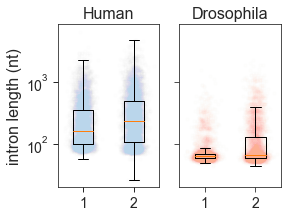

In [41]:
# get intron pair lengths
K562_splice_order_length_df = get_intron_order_lengths(K562_intron_pairs_df, hg38_intron_info)
S2_splice_order_length_df = get_intron_order_lengths(S2_intron_pairs_df, dm6_intron_info)

# plot distribution of intron lengths by splicing order

fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, sharey=True, figsize=(4,3))

# plotting length by splicing order K562 cells
y = np.log10(K562_splice_order_length_df['splice_1'])
x = np.random.normal(1, 0.1, size=len(y)) # Add some random "jitter" to the x-axis
ax1.plot(x, y, '.', color=sns.color_palette("Blues")[1], alpha=0.01)

y = np.log10(K562_splice_order_length_df['splice_2'])
x = np.random.normal(2, 0.1, size=len(y)) # Add some random "jitter" to the x-axis
ax1.plot(x, y, '.', color=sns.color_palette("Blues")[1], alpha=0.01)

plot_list = [np.log10(K562_splice_order_length_df['splice_1']),np.log10(K562_splice_order_length_df['splice_2'])]
ax1.boxplot(plot_list, 0, '', widths=0.4)

# plotting length by splicing order S2 cells
y = np.log10(S2_splice_order_length_df['splice_1'])
x = np.random.normal(1, 0.1, size=len(y)) # Add some random "jitter" to the x-axis
ax2.plot(x, y, '.', color=sns.color_palette("Reds")[1], alpha=0.01)

y = np.log10(S2_splice_order_length_df['splice_2'])
x = np.random.normal(2, 0.1, size=len(y)) # Add some random "jitter" to the x-axis
ax2.plot(x, y, '.', color=sns.color_palette("Reds")[1], alpha=0.01)

plot_list = [np.log10(S2_splice_order_length_df['splice_1']),np.log10(S2_splice_order_length_df['splice_2'])]
ax2 = plt.boxplot(plot_list, 0, '', widths=0.4)


ax1.set_ylabel("intron length (nt)", fontsize=16)
ax1.set_title("Human", fontsize=16)
plt.title("Drosophila", fontsize=16)
    
plt.xticks(fontsize=14)

ax1.xaxis.set_tick_params(labelsize=14, direction='out', length=5, width=1)
ax1.yaxis.set_tick_params(labelsize=14, direction='out', length=5, width=1)

labels = ["$\mathregular{10^{2}}$","$\mathregular{10^{3}}$"]
plt.yticks([2,3], labels, fontsize=20)
ax1.tick_params(axis='both', which='both', labelsize=14, direction='out', left="on", bottom="on", length=5)
plt.tick_params(axis='both', which='both', labelsize=14, direction='out', left="on", bottom="on", length=5)

plt.savefig('/path/to/Figure_5A_K562_S2_order_of_splicing_length_plot.pdf', 
           format='pdf', dpi=300, bbox_inches='tight')

plt.show()

In [42]:
t, p = ttest_ind(K562_splice_order_length_df['splice_1'], K562_splice_order_length_df['splice_2'], equal_var=False)
print("Human intron length t-test p-value = "+str(p))

t, p = ttest_ind(S2_splice_order_length_df['splice_1'], S2_splice_order_length_df['splice_2'], equal_var=False)
print("Drosophila intron t-test length p-value = "+str(p))


Human intron length t-test p-value = 1.9053088755136866e-40
Drosophila intron t-test length p-value = 7.583598615619583e-100


In [43]:
p = scipy.stats.ranksums(K562_splice_order_length_df['splice_1'], K562_splice_order_length_df['splice_2'])[1]
print("Human intron length ranksum p-value = "+str(p))

p = scipy.stats.ranksums(S2_splice_order_length_df['splice_1'], S2_splice_order_length_df['splice_2'])[1]
print("Drosophila intron length ranksum p-value = "+str(p))


Human intron length ranksum p-value = 3.1663363764687824e-34
Drosophila intron length ranksum p-value = 6.125186655252564e-65


In [44]:
### Fig. 5B

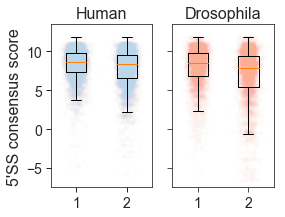

In [45]:
# get intron pair 5SS scores
K562_splice_order_5SSMaxEnt_df = get_MaxEnt_score_5SS(K562_intron_pairs_df, hg38_intron_info)
S2_splice_order_5SSMaxEnt_df = get_MaxEnt_score_5SS(S2_intron_pairs_df, dm6_intron_info)

# plot distribution of intron lengths by splicing order

fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, sharey=True, figsize=(4,3))

# plotting length by splicing order K562 cells
y = K562_splice_order_5SSMaxEnt_df['splice_1']
x = np.random.normal(1, 0.1, size=len(y)) # Add some random "jitter" to the x-axis
ax1.plot(x, y, '.', color=sns.color_palette("Blues")[1], alpha=0.01)

y = K562_splice_order_5SSMaxEnt_df['splice_2']
x = np.random.normal(2, 0.1, size=len(y)) # Add some random "jitter" to the x-axis
ax1.plot(x, y, '.', color=sns.color_palette("Blues")[1], alpha=0.01)

plot_list = [K562_splice_order_5SSMaxEnt_df['splice_1'],K562_splice_order_5SSMaxEnt_df['splice_2']]
ax1.boxplot(plot_list, 0, '', widths=0.4)

# plotting length by splicing order S2 cells
y = S2_splice_order_5SSMaxEnt_df['splice_1']
x = np.random.normal(1, 0.1, size=len(y)) # Add some random "jitter" to the x-axis
ax2.plot(x, y, '.', color=sns.color_palette("Reds")[1], alpha=0.01)

y = S2_splice_order_5SSMaxEnt_df['splice_2']
x = np.random.normal(2, 0.1, size=len(y)) # Add some random "jitter" to the x-axis
ax2.plot(x, y, '.', color=sns.color_palette("Reds")[1], alpha=0.01)

plot_list = [S2_splice_order_5SSMaxEnt_df['splice_1'],S2_splice_order_5SSMaxEnt_df['splice_2']]
ax2 = plt.boxplot(plot_list, 0, '', widths=0.4)

ax1.set_ylabel("5'SS consensus score", fontsize=16)
ax1.set_title("Human", fontsize=16)
plt.title("Drosophila", fontsize=16)
    
plt.xticks(fontsize=14)
plt.ylim(-7.5,13.5)

ax1.xaxis.set_tick_params(labelsize=14, direction='out', length=5, width=1)
ax1.yaxis.set_tick_params(labelsize=14, direction='out', length=5, width=1)
ax1.tick_params(axis='both', which='both', labelsize=14, direction='out', left="on", bottom="on", length=5)
plt.tick_params(axis='both', which='both', labelsize=14, direction='out', left="on", bottom="on", length=5)

plt.savefig('/path/to/Figure_5B_K562_S2_order_of_splicing_5SS_plot.pdf', 
           format='pdf', dpi=300, bbox_inches='tight')

plt.show()


In [46]:
t, p = ttest_ind(K562_splice_order_5SSMaxEnt_df['splice_1'], K562_splice_order_5SSMaxEnt_df['splice_2'], equal_var=False)
print("Human 5'SS score t-test p-value = "+str(p))

t, p = ttest_ind(S2_splice_order_5SSMaxEnt_df['splice_1'], S2_splice_order_5SSMaxEnt_df['splice_2'], equal_var=False)
print("Drosophila 5'SS score t-test p-value = "+str(p))


Human 5'SS score t-test p-value = 9.570391300741703e-37
Drosophila 5'SS score t-test p-value = 3.9177963124787827e-72


In [47]:
p = scipy.stats.ranksums(K562_splice_order_5SSMaxEnt_df['splice_1'], K562_splice_order_5SSMaxEnt_df['splice_2'])[1]
print("Human 5'SS score ranksum p-value = "+str(p))

p = scipy.stats.ranksums(S2_splice_order_5SSMaxEnt_df['splice_1'], S2_splice_order_5SSMaxEnt_df['splice_2'])[1]
print("Drosophila 5'SS score ranksum p-value = "+str(p))


Human 5'SS score ranksum p-value = 2.834207891783417e-26
Drosophila 5'SS score ranksum p-value = 2.5060958735964484e-52


In [48]:
### Fig. 5C

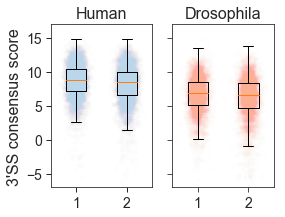

In [49]:
# get intron pair lengths
K562_splice_order_3SSMaxEnt_df = get_MaxEnt_score_3SS(K562_intron_pairs_df, hg38_intron_info)

S2_splice_order_3SSMaxEnt_df = get_MaxEnt_score_3SS(S2_intron_pairs_df, dm6_intron_info)

# plot distribution of intron lengths by splicing order

fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, sharey=True, figsize=(4,3))

# plotting length by splicing order K562 cells
y = K562_splice_order_3SSMaxEnt_df['splice_1']
x = np.random.normal(1, 0.1, size=len(y)) # Add some random "jitter" to the x-axis
ax1.plot(x, y, '.', color=sns.color_palette("Blues")[1], alpha=0.01)

y = K562_splice_order_3SSMaxEnt_df['splice_2']
x = np.random.normal(2, 0.1, size=len(y)) # Add some random "jitter" to the x-axis
ax1.plot(x, y, '.', color=sns.color_palette("Blues")[1], alpha=0.01)

plot_list = [K562_splice_order_3SSMaxEnt_df['splice_1'],K562_splice_order_3SSMaxEnt_df['splice_2']]
ax1.boxplot(plot_list, 0, '', widths=0.4)

# plotting length by splicing order S2 cells
y = S2_splice_order_3SSMaxEnt_df['splice_1']
x = np.random.normal(1, 0.1, size=len(y)) # Add some random "jitter" to the x-axis
ax2.plot(x, y, '.', color=sns.color_palette("Reds")[1], alpha=0.01)

y = S2_splice_order_3SSMaxEnt_df['splice_2']
x = np.random.normal(2, 0.1, size=len(y)) # Add some random "jitter" to the x-axis
ax2.plot(x, y, '.', color=sns.color_palette("Reds")[1], alpha=0.01)

plot_list = [S2_splice_order_3SSMaxEnt_df['splice_1'],S2_splice_order_3SSMaxEnt_df['splice_2']]
ax2 = plt.boxplot(plot_list, 0, '', widths=0.4)


ax1.set_ylabel("3'SS consensus score", fontsize=16)
ax1.set_title("Human", fontsize=16)
plt.title("Drosophila", fontsize=16)
    
plt.xticks(fontsize=14)
plt.ylim(-7,17)

ax1.xaxis.set_tick_params(labelsize=14, direction='out', length=5, width=1)
ax1.yaxis.set_tick_params(labelsize=14, direction='out', length=5, width=1)
ax1.tick_params(axis='both', which='both', labelsize=14, direction='out', left="on", bottom="on", length=5)
plt.tick_params(axis='both', which='both', labelsize=14, direction='out', left="on", bottom="on", length=5)

plt.savefig('/path/to/Figure_5C_K562_S2_order_of_splicing_3SS_plot.pdf', 
           format='pdf', dpi=300, bbox_inches='tight')

plt.show()

In [50]:
t, p = ttest_ind(K562_splice_order_3SSMaxEnt_df['splice_1'], K562_splice_order_3SSMaxEnt_df['splice_2'], equal_var=False)
print("Human intron 3'SS score t-test p-value = "+str(p))

t, p = ttest_ind(S2_splice_order_3SSMaxEnt_df['splice_1'], S2_splice_order_3SSMaxEnt_df['splice_2'], equal_var=False)
print("Drosophila intron 3'SS score t-test p-value = "+str(p))


Human intron 3'SS score t-test p-value = 3.655899215008518e-27
Drosophila intron 3'SS score t-test p-value = 3.3159915290824835e-17


In [51]:
p = scipy.stats.ranksums(K562_splice_order_3SSMaxEnt_df['splice_1'], K562_splice_order_3SSMaxEnt_df['splice_2'])[1]
print("Human 3'SS score ranksum p-value = "+str(p))

p = scipy.stats.ranksums(S2_splice_order_3SSMaxEnt_df['splice_1'], S2_splice_order_3SSMaxEnt_df['splice_2'])[1]
print("Drosophila 3'SS score ranksum p-value = "+str(p))


Human 3'SS score ranksum p-value = 2.0734445876468694e-20
Drosophila 3'SS score ranksum p-value = 3.239176157808811e-11


In [3]:

def get_intron_order_features(intron_pairs_df, intron_info):
    
    intron_pairs_df = intron_pairs_df[intron_pairs_df['int1_splice']!=intron_pairs_df['int2_splice']].reset_index(drop=True)
        
    features1 = pd.merge(intron_pairs_df, intron_info, left_on='int1_name', right_on='name', how='left')
    features2 = pd.merge(intron_pairs_df, intron_info, left_on='int2_name', right_on='name', how='left')
    
    combined = pd.concat([intron_pairs_df['read'],intron_pairs_df['strand']],axis=1)
    
    combined['chrom'] = 'NA'
    combined.loc[combined.strand=='+','chrom'] = features1['chrom_x']
    combined.loc[combined.strand=='-','chrom'] = features2['chrom_x']

    combined['start'] = 'NA'
    combined.loc[combined.strand=='+','start'] = features1['int1_start']
    combined.loc[combined.strand=='-','start'] = features2['int2_start']
    
    combined['end'] = 'NA'
    combined.loc[combined.strand=='+','end'] = features1['int2_end']
    combined.loc[combined.strand=='-','end'] = features2['int1_end']

    combined['name_1'] = 'NA'
    combined.loc[combined.strand=='+','name_1'] = features1['int1_name']
    combined.loc[combined.strand=='-','name_1'] = features2['int2_name']

    combined['length_1'] = 0
    combined.loc[combined.strand=='+','length_1'] = features1['intron_length']
    combined.loc[combined.strand=='-','length_1'] = features2['intron_length']

    combined['uElength_1'] = 0
    combined.loc[combined.strand=='+','uElength_1'] = features1['upstream_exon_length']
    combined.loc[combined.strand=='-','uElength_1'] = features2['upstream_exon_length']

    combined['dElength_1'] = 0
    combined.loc[combined.strand=='+','dElength_1'] = features1['downstream_exon_length']
    combined.loc[combined.strand=='-','dElength_1'] = features2['downstream_exon_length']

    combined['pos_1'] = 0
    combined.loc[combined.strand=='+','pos_1'] = features1['intron_pos']
    combined.loc[combined.strand=='-','pos_1'] = features2['intron_pos']

    combined['order_1'] = 0
    combined.loc[combined.strand=='+','order_1'] = features1['intron_order']
    combined.loc[combined.strand=='-','order_1'] = features2['intron_order']

    combined['trx_1'] = 0

    combined['MaxEnt5SS_1'] = 0.0
    combined.loc[combined.strand=='+','MaxEnt5SS_1'] = features1['MaxEnt_score_5SS']
    combined.loc[combined.strand=='-','MaxEnt5SS_1'] = features2['MaxEnt_score_5SS']

    combined['MaxEnt3SS_1'] = 0.0
    combined.loc[combined.strand=='+','MaxEnt3SS_1'] = features1['MaxEnt_score_3SS']
    combined.loc[combined.strand=='-','MaxEnt3SS_1'] = features2['MaxEnt_score_3SS']

    combined['splice_1'] = 'NA'
    combined.loc[combined.strand=='+','splice_1'] = features1['int1_splice']
    combined.loc[combined.strand=='-','splice_1'] = features2['int2_splice']

    combined['alt_1'] = 'NA'
    combined.loc[combined.strand=='+','alt_1'] = features1['alt']
    combined.loc[combined.strand=='-','alt_1'] = features2['alt']
    combined.loc[combined.alt_1=='NO','alt_1'] = 0
    combined.loc[combined.alt_1=='YES','alt_1'] = 1
    combined.loc[combined.alt_1=='OTHER','alt_1'] = 1
    
    
    combined['name_2'] = 'NA'
    combined.loc[combined.strand=='+','name_2'] = features2['int2_name']
    combined.loc[combined.strand=='-','name_2'] = features1['int1_name']

    combined['length_2'] = 0
    combined.loc[combined.strand=='+','length_2'] = features2['intron_length']
    combined.loc[combined.strand=='-','length_2'] = features1['intron_length']
    
    combined['dElength_2'] = 0
    combined.loc[combined.strand=='+','dElength_2'] = features2['downstream_exon_length']
    combined.loc[combined.strand=='-','dElength_2'] = features1['downstream_exon_length']

    combined['pos_2'] = 0
    combined.loc[combined.strand=='+','pos_2'] = features2['intron_pos']
    combined.loc[combined.strand=='-','pos_2'] = features1['intron_pos']

    combined['order_2'] = 0
    combined.loc[combined.strand=='+','order_2'] = features2['intron_order']
    combined.loc[combined.strand=='-','order_2'] = features1['intron_order']

    combined['trx_2'] = 1

    combined['MaxEnt5SS_2'] = 0.0
    combined.loc[combined.strand=='+','MaxEnt5SS_2'] = features2['MaxEnt_score_5SS']
    combined.loc[combined.strand=='-','MaxEnt5SS_2'] = features1['MaxEnt_score_5SS']
    
    combined['MaxEnt3SS_2'] = 0.0
    combined.loc[combined.strand=='+','MaxEnt3SS_2'] = features2['MaxEnt_score_3SS']
    combined.loc[combined.strand=='-','MaxEnt3SS_2'] = features1['MaxEnt_score_3SS']

    combined['splice_2'] = 'NA'
    combined.loc[combined.strand=='+','splice_2'] = features2['int2_splice']
    combined.loc[combined.strand=='-','splice_2'] = features1['int1_splice']

    combined['alt_2'] = 'NA'
    combined.loc[combined.strand=='+','alt_2'] = features2['alt']
    combined.loc[combined.strand=='-','alt_2'] = features1['alt']
    combined.loc[combined.alt_2=='NO','alt_2'] = 0
    combined.loc[combined.alt_2=='YES','alt_2'] = 1
    combined.loc[combined.alt_2=='OTHER','alt_2'] = 1

    
    combined['splice_order'] = 0
    combined.loc[combined.splice_1=='YES','splice_order'] = 0
    combined.loc[combined.splice_2=='YES','splice_order'] = 1

    return combined


def get_all_feature_importance_RandomForestClassifier(intron_pairs_df, intron_info_wiAlt, TEST_SIZE, RANDOM_STATE, SHUFFLE, N_ESTIMATORS):
    
    # removing duplicate intron pairs
    splicing_order_stats = get_intron_order_features(intron_pairs_df, intron_info_wiAlt)
    splicing_order_stats = splicing_order_stats.drop_duplicates(subset=['name_1','name_2']).reset_index(drop=True)

    features = pd.concat([splicing_order_stats['chrom'],splicing_order_stats['start'],splicing_order_stats['end'],
                          splicing_order_stats['name_1'], splicing_order_stats['length_1'], splicing_order_stats['MaxEnt5SS_1'], splicing_order_stats['MaxEnt3SS_1'],
                          splicing_order_stats['uElength_1'], splicing_order_stats['dElength_1'], splicing_order_stats['pos_1'], splicing_order_stats['alt_1'], 
                          splicing_order_stats['name_2'], splicing_order_stats['length_2'], splicing_order_stats['MaxEnt5SS_2'], splicing_order_stats['MaxEnt3SS_2'],
                          splicing_order_stats['dElength_2'], splicing_order_stats['pos_2'], splicing_order_stats['alt_2'],
                          splicing_order_stats['splice_order']],axis=1)

    #features = features.sort_values(by=['name_1','name_2'])
    features = features.sort_values(by=['chrom','start','end'])
    features = features.drop(['chrom','start','end','name_1', 'name_2'], axis=1)
    
    features = pd.get_dummies(features)
  
    # Labels are the values we want to predict
    labels = np.array(features['splice_order'])

    # Remove the labels from the features
    # axis 1 refers to the columns
    features = features.drop('splice_order', axis = 1)

    # Saving feature names for later use
    feature_list = list(features.columns)

    # Convert to numpy array
    features = np.array(features)

    # Split the data into training and testing sets
    train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = TEST_SIZE, random_state = RANDOM_STATE, shuffle = SHUFFLE)

    # Instantiate model with 1000 decision trees
    rf = RandomForestClassifier(n_estimators = N_ESTIMATORS, random_state = RANDOM_STATE)

    # Train the model on training data
    rf.fit(train_features, train_labels);

    # Use the forest's predict method on the test data
    predictions = rf.predict(test_features)

    # make an ROC curve
    fpr_comb, tpr_comb, _ = roc_curve(test_labels, predictions)
    comb_auc = roc_auc_score(test_labels, predictions)

    # Get numerical feature importances
    importances = list(rf.feature_importances_)

    # List of tuples with variable and importance
    feature_importances = [(feature, round(importance, 4)) for feature, importance in zip(feature_list, importances)]

    # Sort the feature importances by most important first
    feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

    importance_list = []
    for pair in feature_importances:
        
        importance_list.append([pair[0],pair[1]])
        
    importance_df = pd.DataFrame(importance_list)
    importance_df.columns = ['Variable','Importance']
    
    return importance_df


def get_txn_features(splicing_order_stats):
    
    features = pd.concat([splicing_order_stats['chrom'],splicing_order_stats['start'],splicing_order_stats['end'],
                          splicing_order_stats['name_1'], splicing_order_stats['trx_1'],
                          splicing_order_stats['name_2'], splicing_order_stats['trx_2'],
                          splicing_order_stats['splice_order']],axis=1)
    
    features = features.sort_values(by=['chrom','start','end']).reset_index(drop=True)
    features = features.drop(['chrom','start','end','name_1', 'name_2'], axis=1).reset_index(drop=True)

    features = pd.get_dummies(features)

    return features


def get_intron_length_features(splicing_order_stats):
    
    features = pd.concat([splicing_order_stats['chrom'],splicing_order_stats['start'],splicing_order_stats['end'],
                          splicing_order_stats['name_1'], splicing_order_stats['length_1'],
                          splicing_order_stats['name_2'], splicing_order_stats['length_2'],
                          splicing_order_stats['splice_order']],axis=1)
    
    features = features.sort_values(by=['chrom','start','end']).reset_index(drop=True)
    features = features.drop(['chrom','start','end','name_1', 'name_2'], axis=1).reset_index(drop=True)

    features = pd.get_dummies(features)

    return features
    
    
def get_exon_length_features(splicing_order_stats):
    
    features = pd.concat([splicing_order_stats['chrom'],splicing_order_stats['start'],splicing_order_stats['end'],
                          splicing_order_stats['name_1'], splicing_order_stats['uElength_1'], splicing_order_stats['dElength_1'],
                          splicing_order_stats['name_2'], splicing_order_stats['dElength_2'],
                          splicing_order_stats['splice_order']],axis=1)

    features = features.sort_values(by=['chrom','start','end']).reset_index(drop=True)
    features = features.drop(['chrom','start','end','name_1', 'name_2'], axis=1).reset_index(drop=True)
    
    features = pd.get_dummies(features)

    return features


def get_sequence_features(splicing_order_stats):
    
    features = pd.concat([splicing_order_stats['chrom'],splicing_order_stats['start'],splicing_order_stats['end'],
                          splicing_order_stats['name_1'], splicing_order_stats['MaxEnt5SS_1'], splicing_order_stats['MaxEnt3SS_1'],
                          splicing_order_stats['name_2'], splicing_order_stats['MaxEnt5SS_2'], splicing_order_stats['MaxEnt3SS_2'],
                          splicing_order_stats['splice_order']],axis=1)

    features = features.sort_values(by=['chrom','start','end']).reset_index(drop=True)
    features = features.drop(['chrom','start','end','name_1', 'name_2'], axis=1).reset_index(drop=True)

    features = pd.get_dummies(features)

    return features


def get_length_sequence_combined_features(splicing_order_stats):
    
    features = pd.concat([splicing_order_stats['chrom'],splicing_order_stats['start'],splicing_order_stats['end'],
                          splicing_order_stats['name_1'], splicing_order_stats['length_1'], splicing_order_stats['uElength_1'], splicing_order_stats['dElength_1'], splicing_order_stats['MaxEnt5SS_1'], splicing_order_stats['MaxEnt3SS_1'],
                          splicing_order_stats['name_2'], splicing_order_stats['length_2'], splicing_order_stats['dElength_2'], splicing_order_stats['MaxEnt5SS_2'], splicing_order_stats['MaxEnt3SS_2'],
                          splicing_order_stats['splice_order']],axis=1)

    features = features.sort_values(by=['chrom','start','end']).reset_index(drop=True)
    features = features.drop(['chrom','start','end','name_1', 'name_2'], axis=1).reset_index(drop=True)

    features = pd.get_dummies(features)

    return features


def get_position_features(splicing_order_stats):
    
    features = pd.concat([splicing_order_stats['chrom'],splicing_order_stats['start'],splicing_order_stats['end'],
                          splicing_order_stats['name_1'], splicing_order_stats['pos_1'], splicing_order_stats['order_1'],
                          splicing_order_stats['name_2'], splicing_order_stats['pos_2'], splicing_order_stats['order_2'],
                          splicing_order_stats['splice_order']],axis=1)

    features = features.sort_values(by=['chrom','start','end']).reset_index(drop=True)
    features = features.drop(['chrom','start','end','name_1', 'name_2'], axis=1).reset_index(drop=True)

    features = pd.get_dummies(features)

    return features


def get_alt_features(splicing_order_stats):
    
    features = pd.concat([splicing_order_stats['chrom'],splicing_order_stats['start'],splicing_order_stats['end'],
                          splicing_order_stats['name_1'], splicing_order_stats['alt_1'],
                          splicing_order_stats['name_2'], splicing_order_stats['alt_2'],
                          splicing_order_stats['splice_order']],axis=1)

    features = features.sort_values(by=['chrom','start','end']).reset_index(drop=True)
    features = features.drop(['chrom','start','end','name_1', 'name_2'], axis=1).reset_index(drop=True)

    features = pd.get_dummies(features)

    return features


def get_all_combined_features(splicing_order_stats):
    
    features = pd.concat([splicing_order_stats['chrom'],splicing_order_stats['start'],splicing_order_stats['end'],
                          splicing_order_stats['name_1'], splicing_order_stats['length_1'], splicing_order_stats['MaxEnt5SS_1'], splicing_order_stats['MaxEnt3SS_1'],
                          splicing_order_stats['uElength_1'], splicing_order_stats['dElength_1'], splicing_order_stats['alt_1'],
                          splicing_order_stats['pos_1'], splicing_order_stats['order_1'],
                          splicing_order_stats['name_2'], splicing_order_stats['length_2'], splicing_order_stats['MaxEnt5SS_2'], splicing_order_stats['MaxEnt3SS_2'],
                          splicing_order_stats['dElength_2'], splicing_order_stats['alt_2'],
                          splicing_order_stats['pos_2'], splicing_order_stats['order_2'],
                          splicing_order_stats['splice_order']],axis=1)

    features = features.sort_values(by=['chrom','start','end']).reset_index(drop=True)
    features = features.drop(['chrom','start','end','name_1', 'name_2'], axis=1).reset_index(drop=True)

    features = pd.get_dummies(features)

    return features



def get_random_features(splicing_order_stats):
    
    features = pd.concat([splicing_order_stats['chrom'],splicing_order_stats['start'],splicing_order_stats['end'],
                          splicing_order_stats['name_1'], splicing_order_stats['length_1'], splicing_order_stats['uElength_1'], splicing_order_stats['dElength_1'], splicing_order_stats['MaxEnt5SS_1'], splicing_order_stats['MaxEnt3SS_1'],
                          splicing_order_stats['name_2'], splicing_order_stats['length_2'], splicing_order_stats['dElength_2'], splicing_order_stats['MaxEnt5SS_2'], splicing_order_stats['MaxEnt3SS_2'],
                          splicing_order_stats['splice_order']],axis=1)

    features = features.sort_values(by=['chrom','start','end']).reset_index(drop=True)
    features = features.drop(['chrom','start','end','name_1', 'name_2'], axis=1).reset_index(drop=True)
    
    features = pd.get_dummies(features)
    features['splice_order'] = np.random.permutation(features['splice_order'])

    return features


def get_random_forest_classifier_accuracy(features, TEST_SIZE, RANDOM_STATE, SHUFFLE, N_ESTIMATORS, MAX_FEATURES, MAX_DEPTH):
    
    # Labels are the values we want to predict
    labels = np.array(features['splice_order'])

    # Remove the labels from the features
    # axis 1 refers to the columns
    features = features.drop('splice_order', axis = 1)

    # Saving feature names for later use
    feature_list = list(features.columns)

    # Convert to numpy array
    features = np.array(features)

    # Split the data into training and testing sets
    train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = TEST_SIZE, random_state = RANDOM_STATE, shuffle = SHUFFLE)

    # Instantiate model with 1000 decision trees
    rf = RandomForestClassifier(n_estimators = N_ESTIMATORS, random_state = RANDOM_STATE, max_features = MAX_FEATURES, max_depth = MAX_DEPTH)

    # Train the model on training data
    rf.fit(train_features, train_labels);

    # Use the forest's predict method on the test data
    predictions = rf.predict(test_features)

    # Calculate the absolute errors
    errors = abs(predictions - test_labels)

    # Calculate the accuracy of prediction
    accuracy = round(1-np.mean(errors), 2)
    
    return accuracy


def get_random_forest_classifier_ROC(features, TEST_SIZE, RANDOM_STATE, SHUFFLE, N_ESTIMATORS, MAX_FEATURES, MAX_DEPTH):
    
    # Labels are the values we want to predict
    labels = np.array(features['splice_order'])

    # Remove the labels from the features
    # axis 1 refers to the columns
    features = features.drop('splice_order', axis = 1)

    # Saving feature names for later use
    feature_list = list(features.columns)

    # Convert to numpy array
    features = np.array(features)

    # Split the data into training and testing sets
    train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = TEST_SIZE, random_state = RANDOM_STATE, shuffle = SHUFFLE)
    train_features, train_features_lr, train_labels, train_labels_lr = train_test_split(train_features, train_labels, test_size = TEST_SIZE, random_state = RANDOM_STATE, shuffle = SHUFFLE)

    # Instantiate model with 1000 decision trees
    rf = RandomForestClassifier(n_estimators = N_ESTIMATORS, random_state = RANDOM_STATE, max_features = MAX_FEATURES, max_depth = MAX_DEPTH)

    # Train the model on training data
    rf_enc = OneHotEncoder()
    rf_lm = LogisticRegression()
    rf.fit(train_features, train_labels);
    rf_enc.fit(rf.apply(train_features))
    rf_lm.fit(rf_enc.transform(rf.apply(train_features_lr)), train_labels_lr)

    # Use the forest's predict method on the test data
    predictions = rf.predict(test_features)

    # make an ROC curve
    pred_prob = rf_lm.predict_proba(rf_enc.transform(rf.apply(test_features)))[:, 1]
    fpr, tpr, _ = roc_curve(test_labels, pred_prob)
    auc = roc_auc_score(test_labels, pred_prob)

    return fpr, tpr, auc


def get_intron_pairs_df(read_junctions):
    intron_pairs = []

    # loop through all reads in the dictionary
    for read in read_junctions.keys():

        # make a set for all intron pairs within a read
        # this will avoid duplicate pairs being called due to alternative splicing
        uniq_pairs = set()
        uniq_splice_pattern = set()
        
        # loop through all genes that has introns that a read maps to
        for gene in read_junctions[read].keys():

            # only go through genes that have 2 or more introns
            if (len(read_junctions[read][gene]) > 1 ):

                # characterize the number of spliced and unspliced introns in the read
                splice_status = [row[6] for row in read_junctions[read][gene]]
                splice_status_join = '_'.join(splice_status)
                status_count = Counter(splice_status)
                 
                # only process the file if intron pattern hasn't been seen previously
                # for a gene that this read aligns to
                if (splice_status_join not in uniq_splice_pattern):
                    uniq_splice_pattern.add(splice_status_join)

                    spliced_count = status_count['YES']
                    unspliced_count = status_count['NO']

                    # build a dataframe of introns in the gene that map to this read
                    # and are capable of being sequenced if the read has no splicing
                    read_introns_df = pd.DataFrame(read_junctions[read][gene])
                    read_introns_df.columns = ['chrom','start','end','intron_count','strand','read_overlap','splice_status']
                    read_introns_df = read_introns_df[read_introns_df['read_overlap'] > 0].sort_values('intron_count').reset_index(drop=True)

                    # loop through introns that read maps to and find pairs
                    prev_intron_count = -2    # counter for the start becuase no intron should have a negative count

                    for i in range(len(read_introns_df)):
                        intron_count = read_introns_df.iloc[i]['intron_count']
                        intron_chrom = str(read_introns_df.iloc[i]['chrom'])
                        intron_start = str(read_introns_df.iloc[i]['start'])
                        intron_end = str(read_introns_df.iloc[i]['end'])
                        intron_strand = read_introns_df.iloc[i]['strand']
                        intron_splice = read_introns_df.iloc[i]['splice_status']
                        intron_coord = intron_chrom+'_'+intron_start+'_'+intron_end
                        intron_name = str(gene)+"_intron_"+str(intron_count)

                        # if intron counts are sequential (one follows the next)
                        # it is a true intron pair (i.e. neighboring introns)
                        if (intron_count - prev_intron_count == 1):
                            intron_pair_coord = prev_intron_coord+'_'+intron_coord

                            # record information about the read pair only if the coordinates of this
                            # intron pair have not yet been seen
                            if (intron_pair_coord not in uniq_pairs): 
                                uniq_pairs.add(intron_pair_coord)
                                prev_intron_start = prev_intron_coord.split('_')[1]
                                prev_intron_end = prev_intron_coord.split('_')[2]

                                # append intron pair coordinate and splicing information to a list
                                intron_pairs.append([read, intron_chrom, intron_strand, prev_intron_name, intron_name, 
                                                     prev_intron_start,prev_intron_end, int(intron_start),int(intron_end),
                                                     prev_intron_splice, intron_splice])

                        # save information about this intron for the next pair
                        prev_intron_count = intron_count
                        prev_intron_coord = intron_coord
                        prev_intron_splice = intron_splice
                        prev_intron_name = intron_name

    intron_pairs_df = pd.DataFrame(intron_pairs)
    intron_pairs_df.columns = ['read','chrom','strand','int1_name','int2_name','int1_start','int1_end','int2_start','int2_end','int1_splice','int2_splice']        

    return intron_pairs_df


def get_random_forest_classifier_train_test_sizes(features, TEST_SIZE, RANDOM_STATE, SHUFFLE, N_ESTIMATORS, MAX_FEATURES, MAX_DEPTH):
    
    # Labels are the values we want to predict
    labels = np.array(features['splice_order'])

    # Remove the labels from the features
    # axis 1 refers to the columns
    features = features.drop('splice_order', axis = 1)

    # Saving feature names for later use
    feature_list = list(features.columns)

    # Convert to numpy array
    features = np.array(features)

    # Split the data into training and testing sets
    train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = TEST_SIZE, random_state = RANDOM_STATE, shuffle = SHUFFLE)

    return len(train_features), len(test_features)
               

In [4]:
# SUPPLEMENTAL FIGURE 6A - global levels of splicing across reads that span two or more introns

# load dictionary with all intron junctions that a read spans
K562_1_splice_dictionary = np.load('/path/to/K562_1_splicing_dictionary.npy', encoding = 'latin1').item() 
K562_2_splice_dictionary = np.load('/path/to/K562_2_splicing_dictionary.npy', encoding = 'latin1').item() 
K562_3_splice_dictionary = np.load('/path/to/K562_3_splicing_dictionary.npy', encoding = 'latin1').item() 
K562_4_splice_dictionary = np.load('/path/to/K562_4_splicing_dictionary.npy', encoding = 'latin1').item() 
K562_5a_splice_dictionary = np.load('/path/to/K562_5a_splicing_dictionary.npy', encoding = 'latin1').item() 
K562_5b_splice_dictionary = np.load('/path/to/K562_5b_splicing_dictionary.npy', encoding = 'latin1').item() 

# get intron pairs plus names/coordinates
K562_1_intron_pairs_coord_df = get_intron_pairs_df(K562_1_splice_dictionary)
K562_2_intron_pairs_coord_df = get_intron_pairs_df(K562_2_splice_dictionary)
K562_3_intron_pairs_coord_df = get_intron_pairs_df(K562_3_splice_dictionary)
K562_4_intron_pairs_coord_df = get_intron_pairs_df(K562_4_splice_dictionary)
K562_5a_intron_pairs_coord_df = get_intron_pairs_df(K562_5a_splice_dictionary)
K562_5b_intron_pairs_coord_df = get_intron_pairs_df(K562_5b_splice_dictionary)
allK562_intron_pairs_df = pd.concat([K562_1_intron_pairs_coord_df,K562_2_intron_pairs_coord_df,K562_3_intron_pairs_coord_df,K562_4_intron_pairs_coord_df,K562_5a_intron_pairs_coord_df,K562_5b_intron_pairs_coord_df],axis=0)
allK562_intron_pairs_df['chrom']='chr'+allK562_intron_pairs_df['chrom']


In [6]:
# upload file with information about all introns in hg38
hg38_intron_info = pd.read_table('/path/to/annotation_files/hg38_all_intron_features.txt')

# combine with alternative splicing information for hg38
hg38_alt_df = pd.read_table('/path/to/annotation_files/hg38_RefSeq_introns_parsed_wiAltFinal.txt', low_memory=False)
hg38_alt_df = hg38_alt_df.drop(['Unnamed: 0'],axis=1)
hg38_alt_df['chrom'] = 'chr'+hg38_alt_df['chrom'].astype(str)
hg38_alt_df = pd.concat([hg38_alt_df['name'],hg38_alt_df['ALT_SPLICE_FINAL']], axis=1)
hg38_alt_df.columns = ['name','alt']
hg38_intron_info_wiAlt = hg38_intron_info.merge(hg38_alt_df, on='name', how='left')

# get splicing order stats file
allK562_splicing_order_stats = get_intron_order_features(allK562_intron_pairs_df, hg38_intron_info_wiAlt)


In [7]:
# load dictionary with all intron junctions that a read spans
S2_1a_splice_dictionary = np.load('/path/to/S2_1a_splicing_dictionary.npy', encoding = 'latin1').item() 
S2_1b_splice_dictionary = np.load('/path/to/S2_1b_splicing_dictionary.npy', encoding = 'latin1').item() 
S2_3_splice_dictionary = np.load('/path/to/S2_3_splicing_dictionary.npy', encoding = 'latin1').item() 
S2_3_splice_dictionary = np.load('/path/to/S2_3_splicing_dictionary.npy', encoding = 'latin1').item() 

# get intron pairs plus names/coordinates
S2_1a_intron_pairs_coord_df = get_intron_pairs_df(S2_1a_splice_dictionary)
S2_1b_intron_pairs_coord_df = get_intron_pairs_df(S2_1b_splice_dictionary)
S2_3_intron_pairs_coord_df = get_intron_pairs_df(S2_3_splice_dictionary)
S2_3_intron_pairs_coord_df = get_intron_pairs_df(S2_3_splice_dictionary)

allS2_intron_pairs_df = pd.concat([S2_1a_intron_pairs_coord_df,S2_1b_intron_pairs_coord_df,S2_3_intron_pairs_coord_df,S2_3_intron_pairs_coord_df],axis=0)


In [8]:
# upload file with information about all introns in dmel6
dm6_intron_info = pd.read_table('/path/to/annotation_files/dmel6_all_intron_features.txt')

# combine with alternative splicing information for dmel6
dm6_alt_df = pd.read_table('/path/to/annotation_files/dm6_RefSeq_introns_parsed_wiAltFinal_v2.txt', index_col=0)
dm6_alt_df = pd.concat([dm6_alt_df['name'],dm6_alt_df['ALT_SPLICE_FINAL']], axis=1)
dm6_alt_df.columns = ['name','alt']
dm6_intron_info_wiAlt = dm6_intron_info.merge(dm6_alt_df, on='name', how='left')

# get splicing order stats file
allS2_splicing_order_stats = get_intron_order_features(allS2_intron_pairs_df, dm6_intron_info_wiAlt)



In [57]:
# get importance levels for all features 

TEST_SIZE = 0.25
RANDOM_STATE = None
SHUFFLE = False
N_ESTIMATORS = 300

allS2_combined_importance_classifier = get_all_feature_importance_RandomForestClassifier(allS2_intron_pairs_df, dm6_intron_info_wiAlt, TEST_SIZE, RANDOM_STATE, SHUFFLE, N_ESTIMATORS)

allK562_combined_importance_classifier = get_all_feature_importance_RandomForestClassifier(allK562_intron_pairs_df, hg38_intron_info_wiAlt, TEST_SIZE, RANDOM_STATE, SHUFFLE, N_ESTIMATORS)


In [58]:
allS2_combined_importance_classifier

,Variable,Importance
0,length_1,0.1519
1,dElength_1,0.1040
2,MaxEnt5SS_1,0.1024
3,length_2,0.1022
4,MaxEnt5SS_2,0.0904
5,MaxEnt3SS_1,0.0842
6,uElength_1,0.0837
7,dElength_2,0.0818
8,MaxEnt3SS_2,0.0782
9,pos_2,0.0377


In [59]:
allK562_combined_importance_classifier

,Variable,Importance
0,length_2,0.1150
1,length_1,0.1085
2,MaxEnt5SS_1,0.0970
3,MaxEnt5SS_2,0.0963
4,MaxEnt3SS_1,0.0916
5,MaxEnt3SS_2,0.0899
6,dElength_1,0.0858
7,uElength_1,0.0824
8,dElength_2,0.0821
9,pos_1,0.0571


In [9]:
# collect features for S2
all_S2_length_features = get_intron_length_features(allS2_splicing_order_stats)
all_S2_exon_length_features = get_exon_length_features(allS2_splicing_order_stats)
all_S2_sequence_features = get_sequence_features(allS2_splicing_order_stats)
all_S2_seq_length_combined_features = get_length_sequence_combined_features(allS2_splicing_order_stats)
all_S2_position_features = get_position_features(allS2_splicing_order_stats)
all_S2_alt_features = get_alt_features(allS2_splicing_order_stats)
all_S2_all_combined_features = get_all_combined_features(allS2_splicing_order_stats)
all_S2_random_features = get_random_features(allS2_splicing_order_stats)

# collect features for K562
all_K562_length_features = get_intron_length_features(allK562_splicing_order_stats)
all_K562_exon_length_features = get_exon_length_features(allK562_splicing_order_stats)
all_K562_sequence_features = get_sequence_features(allK562_splicing_order_stats)
all_K562_seq_length_combined_features = get_length_sequence_combined_features(allK562_splicing_order_stats)
all_K562_position_features = get_position_features(allK562_splicing_order_stats)
all_K562_alt_features = get_alt_features(allK562_splicing_order_stats)
all_K562_all_combined_features = get_all_combined_features(allK562_splicing_order_stats)
all_K562_random_features = get_random_features(allK562_splicing_order_stats)


In [10]:
all_S2_trx_features = get_txn_features(allS2_splicing_order_stats)
all_K562_trx_features = get_txn_features(allK562_splicing_order_stats)


In [62]:
### Fig. 5D

In [64]:
#################### testing random forest parameters with a validation set ####################

limit = int(np.round(len(all_K562_length_features)*3/4))

TEST_SIZE = 0.25
RANDOM_STATE = None
N_ESTIMATORS = 300
MAX_FEATURES = 'log2'
MAX_DEPTH = None
SHUFFLE = False

for i in [10,100,200,300,400,500,1000]:
   
    N_ESTIMATORS=i

    all_K562_all_combined_features_accuracy = get_random_forest_classifier_accuracy(all_K562_all_combined_features[0:np.round(limit)], TEST_SIZE, RANDOM_STATE, SHUFFLE, N_ESTIMATORS, MAX_FEATURES, MAX_DEPTH)
    print('N_ESTIMATORS: '+str(N_ESTIMATORS)+'\tcombined prediction accuracy: '+str(all_K562_all_combined_features_accuracy))


N_ESTIMATORS: 10	combined prediction accuracy: 0.62
N_ESTIMATORS: 100	combined prediction accuracy: 0.66
N_ESTIMATORS: 200	combined prediction accuracy: 0.65
N_ESTIMATORS: 300	combined prediction accuracy: 0.64
N_ESTIMATORS: 400	combined prediction accuracy: 0.63
N_ESTIMATORS: 500	combined prediction accuracy: 0.63
N_ESTIMATORS: 1000	combined prediction accuracy: 0.64


In [67]:
limit = int(np.round(len(all_K562_length_features)*3/4))

TEST_SIZE = 0.25
RANDOM_STATE = None
N_ESTIMATORS = 300
MAX_FEATURES = 'log2'
MAX_DEPTH = None
SHUFFLE = False

for i in ['auto','sqrt','log2',None]:
   
    MAX_FEATURES=i

    all_K562_all_combined_features_accuracy = get_random_forest_classifier_accuracy(all_K562_all_combined_features[0:np.round(limit)], TEST_SIZE, RANDOM_STATE, SHUFFLE, N_ESTIMATORS, MAX_FEATURES, MAX_DEPTH)
    print('MAX_FEATURES: '+str(MAX_FEATURES)+'\tcombined prediction accuracy: '+str(all_K562_all_combined_features_accuracy))


MAX_FEATURES: auto	combined prediction accuracy: 0.62
MAX_FEATURES: sqrt	combined prediction accuracy: 0.64
MAX_FEATURES: log2	combined prediction accuracy: 0.64
MAX_FEATURES: None	combined prediction accuracy: 0.65


In [68]:
limit = int(np.round(len(all_K562_length_features)*3/4))

TEST_SIZE = 0.25
RANDOM_STATE = None
N_ESTIMATORS = 300
MAX_FEATURES = 'log2'
MAX_DEPTH = None
SHUFFLE = False

for i in [1,10,100,500,1000,None]:
   
    MAX_DEPTH=i

    all_K562_all_combined_features_accuracy = get_random_forest_classifier_accuracy(all_K562_all_combined_features[0:np.round(limit)], TEST_SIZE, RANDOM_STATE, SHUFFLE, N_ESTIMATORS, MAX_FEATURES, MAX_DEPTH)
    print('MAX_DEPTH: '+str(MAX_DEPTH)+'\tcombined prediction accuracy: '+str(all_K562_all_combined_features_accuracy))


MAX_DEPTH: 1	combined prediction accuracy: 0.57
MAX_DEPTH: 10	combined prediction accuracy: 0.64
MAX_DEPTH: 100	combined prediction accuracy: 0.65
MAX_DEPTH: 500	combined prediction accuracy: 0.63
MAX_DEPTH: 1000	combined prediction accuracy: 0.63
MAX_DEPTH: None	combined prediction accuracy: 0.64


In [69]:
limit = int(np.round(len(all_K562_length_features)*3/4))

TEST_SIZE = 0.25
RANDOM_STATE = None
N_ESTIMATORS = 300
MAX_FEATURES = None
MAX_DEPTH = None
SHUFFLE = False

all_K562_length_features_accuracy = get_random_forest_classifier_accuracy(all_K562_length_features[0:np.round(limit)], TEST_SIZE, RANDOM_STATE, SHUFFLE, N_ESTIMATORS, MAX_FEATURES, MAX_DEPTH)
all_K562_exon_length_features_accuracy = get_random_forest_classifier_accuracy(all_K562_exon_length_features[0:np.round(limit)], TEST_SIZE, RANDOM_STATE, SHUFFLE, N_ESTIMATORS, MAX_FEATURES, MAX_DEPTH)
all_K562_sequence_features_accuracy = get_random_forest_classifier_accuracy(all_K562_sequence_features[0:np.round(limit)], TEST_SIZE, RANDOM_STATE, SHUFFLE, N_ESTIMATORS, MAX_FEATURES, MAX_DEPTH)
all_K562_position_features_accuracy = get_random_forest_classifier_accuracy(all_K562_position_features[0:np.round(limit)], TEST_SIZE, RANDOM_STATE, SHUFFLE, N_ESTIMATORS, MAX_FEATURES, MAX_DEPTH)
all_K562_alt_features_accuracy = get_random_forest_classifier_accuracy(all_K562_alt_features[0:np.round(limit)], TEST_SIZE, RANDOM_STATE, SHUFFLE, N_ESTIMATORS, MAX_FEATURES, MAX_DEPTH)
all_K562_all_combined_features_accuracy = get_random_forest_classifier_accuracy(all_K562_all_combined_features[0:np.round(limit)], TEST_SIZE, RANDOM_STATE, SHUFFLE, N_ESTIMATORS, MAX_FEATURES, MAX_DEPTH)
all_K562_trx_features_accuracy = get_random_forest_classifier_accuracy(all_K562_trx_features[0:np.round(limit)], TEST_SIZE, RANDOM_STATE, SHUFFLE, N_ESTIMATORS, MAX_FEATURES, MAX_DEPTH)
all_K562_random_features_accuracy = get_random_forest_classifier_accuracy(all_K562_random_features[0:np.round(limit)], TEST_SIZE, RANDOM_STATE, SHUFFLE, N_ESTIMATORS, MAX_FEATURES, MAX_DEPTH)

print('intron length prediction accuracy: '+str(all_K562_length_features_accuracy))
print('exon length prediction accuracy: '+str(all_K562_exon_length_features_accuracy))
print('sequence prediction accuracy: '+str(all_K562_sequence_features_accuracy))
print('positional prediction accuracy: '+str(all_K562_position_features_accuracy))
print('alt splicing prediction accuracy: '+str(all_K562_alt_features_accuracy))
print('combined prediction accuracy: '+str(all_K562_all_combined_features_accuracy))
print('null prediction accuracy: '+str(all_K562_trx_features_accuracy))
print('random prediction accuracy: '+str(all_K562_random_features_accuracy))


intron length prediction accuracy: 0.55
exon length prediction accuracy: 0.54
sequence prediction accuracy: 0.54
positional prediction accuracy: 0.5
alt splicing prediction accuracy: 0.55
combined prediction accuracy: 0.64
null prediction accuracy: 0.53
random prediction accuracy: 0.5


In [444]:
# S2 rf classifier
limit = int(np.round(len(all_K562_length_features)*3/4))

TEST_SIZE = 0.25
RANDOM_STATE = None
N_ESTIMATORS = 300
MAX_FEATURES = None
MAX_DEPTH = None
SHUFFLE = False

all_S2_length_features_accuracy = get_random_forest_classifier_accuracy(all_S2_length_features[0:np.round(limit)], TEST_SIZE, RANDOM_STATE, SHUFFLE, N_ESTIMATORS, MAX_FEATURES, MAX_DEPTH)
all_S2_exon_length_features_accuracy = get_random_forest_classifier_accuracy(all_S2_exon_length_features[0:np.round(limit)], TEST_SIZE, RANDOM_STATE, SHUFFLE, N_ESTIMATORS, MAX_FEATURES, MAX_DEPTH)
all_S2_sequence_features_accuracy = get_random_forest_classifier_accuracy(all_S2_sequence_features[0:np.round(limit)], TEST_SIZE, RANDOM_STATE, SHUFFLE, N_ESTIMATORS, MAX_FEATURES, MAX_DEPTH)
all_S2_position_features_accuracy = get_random_forest_classifier_accuracy(all_S2_position_features[0:np.round(limit)], TEST_SIZE, RANDOM_STATE, SHUFFLE, N_ESTIMATORS, MAX_FEATURES, MAX_DEPTH)
all_S2_alt_features_accuracy = get_random_forest_classifier_accuracy(all_S2_alt_features[0:np.round(limit)], TEST_SIZE, RANDOM_STATE, SHUFFLE, N_ESTIMATORS, MAX_FEATURES, MAX_DEPTH)
all_S2_all_combined_features_accuracy = get_random_forest_classifier_accuracy(all_S2_all_combined_features[0:np.round(limit)], TEST_SIZE, RANDOM_STATE, SHUFFLE, N_ESTIMATORS, MAX_FEATURES, MAX_DEPTH)
all_S2_trx_features_accuracy = get_random_forest_classifier_accuracy(all_S2_trx_features[0:np.round(limit)], TEST_SIZE, RANDOM_STATE, SHUFFLE, N_ESTIMATORS, MAX_FEATURES, MAX_DEPTH)
all_S2_random_features_accuracy = get_random_forest_classifier_accuracy(all_S2_random_features[0:np.round(limit)], TEST_SIZE, RANDOM_STATE, SHUFFLE, N_ESTIMATORS, MAX_FEATURES, MAX_DEPTH)

print('intron length prediction accuracy: '+str(all_S2_length_features_accuracy))
print('exon length prediction accuracy: '+str(all_S2_exon_length_features_accuracy))
print('sequence prediction accuracy: '+str(all_S2_sequence_features_accuracy))
print('positional prediction accuracy: '+str(all_S2_position_features_accuracy))
print('alt splicing prediction accuracy: '+str(all_S2_alt_features_accuracy))
print('combined prediction accuracy: '+str(all_S2_all_combined_features_accuracy))
print('null prediction accuracy: '+str(all_S2_trx_features_accuracy))
print('random prediction accuracy: '+str(all_S2_random_features_accuracy))


intron length prediction accuracy: 0.67
exon length prediction accuracy: 0.61
sequence prediction accuracy: 0.63
positional prediction accuracy: 0.67
alt splicing prediction accuracy: 0.68
combined prediction accuracy: 0.75
null prediction accuracy: 0.67
random prediction accuracy: 0.66


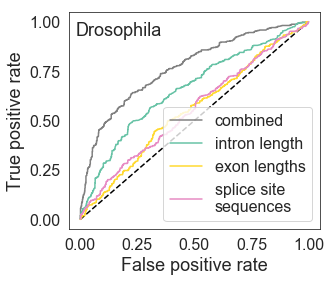

In [448]:
# S2 rf classifier

TEST_SIZE = 0.25
RANDOM_STATE = None
N_ESTIMATORS = 300
MAX_FEATURES = None
MAX_DEPTH = None
SHUFFLE = False

fpr_ilength, tpr_ilength, ilength_auc = get_random_forest_classifier_ROC(all_S2_length_features, TEST_SIZE, RANDOM_STATE, SHUFFLE, N_ESTIMATORS, MAX_FEATURES, MAX_DEPTH)
fpr_elength, tpr_elength, elength_auc  = get_random_forest_classifier_ROC(all_S2_exon_length_features, TEST_SIZE, RANDOM_STATE, SHUFFLE, N_ESTIMATORS, MAX_FEATURES, MAX_DEPTH)
fpr_seq, tpr_seq, seq_auc = get_random_forest_classifier_ROC(all_S2_sequence_features, TEST_SIZE, RANDOM_STATE, SHUFFLE, N_ESTIMATORS, MAX_FEATURES, MAX_DEPTH)
fpr_comb, tpr_comb, comb_auc = get_random_forest_classifier_ROC(all_S2_seq_length_combined_features, TEST_SIZE, RANDOM_STATE, SHUFFLE, N_ESTIMATORS, MAX_FEATURES, MAX_DEPTH)
#fpr_rand, tpr_rand, rand_auc = get_random_forest_classifier_ROC(all_S2_random_features, TEST_SIZE, RANDOM_STATE, SHUFFLE, N_ESTIMATORS, MAX_FEATURES, MAX_DEPTH)

plt.subplots(figsize=(4.5,4))

col_list = ['lightblue', 'gold', 'thistle', 'lightcoral', 'orange', 'yellowgreen', 'lightgray']

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_comb, tpr_comb, label='combined', color='grey')
plt.plot(fpr_ilength, tpr_ilength, label='intron length', color=sns.color_palette("Set2")[0])
plt.plot(fpr_elength, tpr_elength, label='exon lengths', color=sns.color_palette("Set2")[5])
plt.plot(fpr_seq, tpr_seq, label='splice site\nsequences', color=sns.color_palette("Set2")[3])
#plt.plot(fpr_rand, tpr_rand, label='random', color=sns.color_palette("Set2")[1])
plt.xlabel('False positive rate', fontsize=18)
plt.ylabel('True positive rate', fontsize=18)
plt.title('')
plt.legend(loc='best', fontsize=16)
plt.text(-.02, 1, 'Drosophila', horizontalalignment='left', verticalalignment='top', fontsize=18)

plt.xticks([0.0,0.25,0.50,0.75,1.0],fontsize=16)
plt.yticks([0.0,0.25,0.50,0.75,1.0],fontsize=16)
plt.tick_params(direction='out', length=5, width=1)

plt.savefig('/path/to/Figure_5D_S2_splicing_order_model_ROC_plot.pdf', 
           format='pdf', dpi=300, bbox_inches='tight')

plt.show()


In [449]:
print('combined AUC = %0.2f' % (comb_auc))
print('intron length AUC = %0.2f' % (ilength_auc))
print('exon length AUC = %0.2f' % (elength_auc))
print('splice site sequences AUC = %0.2f' % (seq_auc))
#print('random AUC = %0.2f' % (rand_auc))

combined AUC = 0.77
intron length AUC = 0.66
exon length AUC = 0.55
splice site sequences AUC = 0.55


In [ ]:
### Fig. 5E

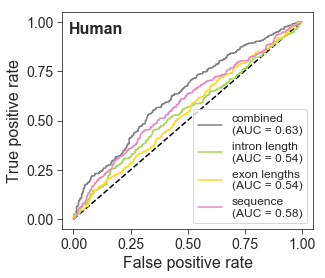

In [80]:
# K562 rf classifier

TEST_SIZE = 0.25
RANDOM_STATE = None
N_ESTIMATORS = 300
MAX_FEATURES = None
MAX_DEPTH = None
SHUFFLE = False

fpr_ilength, tpr_ilength, ilength_auc = get_random_forest_classifier_ROC(all_K562_length_features, TEST_SIZE, RANDOM_STATE, SHUFFLE, N_ESTIMATORS, MAX_FEATURES, MAX_DEPTH)
fpr_elength, tpr_elength, elength_auc  = get_random_forest_classifier_ROC(all_K562_exon_length_features, TEST_SIZE, RANDOM_STATE, SHUFFLE, N_ESTIMATORS, MAX_FEATURES, MAX_DEPTH)
fpr_seq, tpr_seq, seq_auc = get_random_forest_classifier_ROC(all_K562_sequence_features, TEST_SIZE, RANDOM_STATE, SHUFFLE, N_ESTIMATORS, MAX_FEATURES, MAX_DEPTH)
fpr_comb, tpr_comb, comb_auc = get_random_forest_classifier_ROC(all_K562_seq_length_combined_features, TEST_SIZE, RANDOM_STATE, SHUFFLE, N_ESTIMATORS, MAX_FEATURES, MAX_DEPTH)

plt.subplots(figsize=(4.5,4))

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_comb, tpr_comb, label='combined\n(AUC = %0.2f)' % (comb_auc), color='grey')
plt.plot(fpr_ilength, tpr_ilength, label='intron length\n(AUC = %0.2f)' % (ilength_auc), color=sns.color_palette("Set2")[4])
plt.plot(fpr_elength, tpr_elength, label='exon lengths\n(AUC = %0.2f)' % (elength_auc), color=sns.color_palette("Set2")[5])
plt.plot(fpr_seq, tpr_seq, label='sequence\n(AUC = %0.2f)' % (seq_auc), color=sns.color_palette("Set2")[3])
plt.xlabel('False positive rate', fontsize=16)
plt.ylabel('True positive rate', fontsize=16)
plt.title('')
plt.legend(loc='best', fontsize=12)
plt.text(-.02, 1, 'Human', horizontalalignment='left', verticalalignment='top', fontsize=16, weight='bold')

plt.xticks([0.0,0.25,0.50,0.75,1.0],fontsize=16)
plt.yticks([0.0,0.25,0.50,0.75,1.0],fontsize=16)
plt.tick_params(axis='both', which='both', labelsize=14, direction='out', left="on", bottom="on", length=5)

plt.savefig('/path/to/Figure_5E_K562_splicing_order_model_ROC_plot.pdf', 
           format='pdf', dpi=300, bbox_inches='tight')

plt.show()


In [79]:
print('combined AUC = %0.2f' % (comb_auc))
print('intron length AUC = %0.2f' % (ilength_auc))
print('exon length AUC = %0.2f' % (elength_auc))
print('splice site sequences AUC = %0.2f' % (seq_auc))

combined AUC = 0.63
intron length AUC = 0.54
exon length AUC = 0.54
splice site sequences AUC = 0.58


In [386]:
# S2 rf classifier

TEST_SIZE = 0.25
RANDOM_STATE = None
N_ESTIMATORS = 300
MAX_FEATURES = None
MAX_DEPTH = None
SHUFFLE = False

all_S2_length_features_accuracy = get_random_forest_classifier_accuracy(all_S2_length_features, TEST_SIZE, RANDOM_STATE, SHUFFLE, N_ESTIMATORS, MAX_FEATURES, MAX_DEPTH)
all_S2_exon_length_features_accuracy = get_random_forest_classifier_accuracy(all_S2_exon_length_features, TEST_SIZE, RANDOM_STATE, SHUFFLE, N_ESTIMATORS, MAX_FEATURES, MAX_DEPTH)
all_S2_sequence_features_accuracy = get_random_forest_classifier_accuracy(all_S2_sequence_features, TEST_SIZE, RANDOM_STATE, SHUFFLE, N_ESTIMATORS, MAX_FEATURES, MAX_DEPTH)
all_S2_position_features_accuracy = get_random_forest_classifier_accuracy(all_S2_position_features, TEST_SIZE, RANDOM_STATE, SHUFFLE, N_ESTIMATORS, MAX_FEATURES, MAX_DEPTH)
all_S2_alt_features_accuracy = get_random_forest_classifier_accuracy(all_S2_alt_features, TEST_SIZE, RANDOM_STATE, SHUFFLE, N_ESTIMATORS, MAX_FEATURES, MAX_DEPTH)
all_S2_all_combined_features_accuracy = get_random_forest_classifier_accuracy(all_S2_all_combined_features, TEST_SIZE, RANDOM_STATE, SHUFFLE, N_ESTIMATORS, MAX_FEATURES, MAX_DEPTH)
all_S2_trx_features_accuracy = get_random_forest_classifier_accuracy(all_S2_trx_features, TEST_SIZE, RANDOM_STATE, SHUFFLE, N_ESTIMATORS, MAX_FEATURES, MAX_DEPTH)

print('intron length prediction accuracy: '+str(all_S2_length_features_accuracy))
print('exon length prediction accuracy: '+str(all_S2_exon_length_features_accuracy))
print('sequence prediction accuracy: '+str(all_S2_sequence_features_accuracy))
print('positional prediction accuracy: '+str(all_S2_position_features_accuracy))
print('alt splicing prediction accuracy: '+str(all_S2_alt_features_accuracy))
print('combined prediction accuracy: '+str(all_S2_all_combined_features_accuracy))
print('null prediction accuracy: '+str(all_S2_trx_features_accuracy))


intron length prediction accuracy: 0.66
exon length prediction accuracy: 0.6
sequence prediction accuracy: 0.62
positional prediction accuracy: 0.63
alt splicing prediction accuracy: 0.66
combined prediction accuracy: 0.76
null prediction accuracy: 0.64


In [81]:
# K562 rf classifier

TEST_SIZE = 0.25
RANDOM_STATE = None
N_ESTIMATORS = 300
MAX_FEATURES = None
MAX_DEPTH = None
SHUFFLE = False

all_K562_length_features_accuracy = get_random_forest_classifier_accuracy(all_K562_length_features, TEST_SIZE, RANDOM_STATE, SHUFFLE, N_ESTIMATORS, MAX_FEATURES, MAX_DEPTH)
all_K562_exon_length_features_accuracy = get_random_forest_classifier_accuracy(all_K562_exon_length_features, TEST_SIZE, RANDOM_STATE, SHUFFLE, N_ESTIMATORS, MAX_FEATURES, MAX_DEPTH)
all_K562_sequence_features_accuracy = get_random_forest_classifier_accuracy(all_K562_sequence_features, TEST_SIZE, RANDOM_STATE, SHUFFLE, N_ESTIMATORS, MAX_FEATURES, MAX_DEPTH)
all_K562_position_features_accuracy = get_random_forest_classifier_accuracy(all_K562_position_features, TEST_SIZE, RANDOM_STATE, SHUFFLE, N_ESTIMATORS, MAX_FEATURES, MAX_DEPTH)
all_K562_alt_features_accuracy = get_random_forest_classifier_accuracy(all_K562_alt_features, TEST_SIZE, RANDOM_STATE, SHUFFLE, N_ESTIMATORS, MAX_FEATURES, MAX_DEPTH)
all_K562_all_combined_features_accuracy = get_random_forest_classifier_accuracy(all_K562_all_combined_features, TEST_SIZE, RANDOM_STATE, SHUFFLE, N_ESTIMATORS, MAX_FEATURES, MAX_DEPTH)
all_K562_trx_features_accuracy = get_random_forest_classifier_accuracy(all_K562_trx_features, TEST_SIZE, RANDOM_STATE, SHUFFLE, N_ESTIMATORS, MAX_FEATURES, MAX_DEPTH)

print('intron length prediction accuracy: '+str(all_K562_length_features_accuracy))
print('exon length prediction accuracy: '+str(all_K562_exon_length_features_accuracy))
print('sequence prediction accuracy: '+str(all_K562_sequence_features_accuracy))
print('positional prediction accuracy: '+str(all_K562_position_features_accuracy))
print('alt splicing prediction accuracy: '+str(all_K562_alt_features_accuracy))
print('combined prediction accuracy: '+str(all_K562_all_combined_features_accuracy))
print('null prediction accuracy: '+str(all_K562_trx_features_accuracy))


intron length prediction accuracy: 0.56
exon length prediction accuracy: 0.55
sequence prediction accuracy: 0.55
positional prediction accuracy: 0.49
alt splicing prediction accuracy: 0.53
combined prediction accuracy: 0.6
null prediction accuracy: 0.51


In [232]:
TEST_SIZE = 0.25
RANDOM_STATE = None
N_ESTIMATORS = 300
MAX_FEATURES = None
MAX_DEPTH = None
SHUFFLE = False

all_K562_train_size, all_K562_test_size = get_random_forest_classifier_train_test_sizes(all_K562_length_features, TEST_SIZE, RANDOM_STATE, SHUFFLE, N_ESTIMATORS, MAX_FEATURES, MAX_DEPTH)
print("K562 train size: "+str(all_K562_train_size))
print("K562 test size: "+str(all_K562_test_size))

all_S2_train_size, all_S2_test_size = get_random_forest_classifier_train_test_sizes(all_S2_length_features, TEST_SIZE, RANDOM_STATE, SHUFFLE, N_ESTIMATORS, MAX_FEATURES, MAX_DEPTH)
print("S2 train size: "+str(all_S2_train_size))
print("S2 test size: "+str(all_S2_test_size))



K562 train size: 4518
K562 test size: 1506
S2 train size: 3949
S2 test size: 1317


In [3]:
def get_intron_order_eclip(intron_pairs_df, intron_info, RBP):
    
    # Getting eCLIP data for each intron within the pair
    eclip1 = pd.merge(intron_pairs_df, intron_info, left_on=['chrom','int1_start','int1_end','strand'], right_on=['chrom','start','end','strand'], how='left')[RBP]
    eclip2 = pd.merge(intron_pairs_df, intron_info, left_on=['chrom','int2_start','int2_end','strand'], right_on=['chrom','start','end','strand'], how='left')[RBP]
    
    # Combining data from intron_pairs and from eCLIP density profiles (in a specific order of columns)
    combined = pd.concat([intron_pairs_df['read'],intron_pairs_df[['chrom','int1_start','int1_end','int1_splice']],intron_pairs_df[['int2_start','int2_end','int2_splice']],eclip1,eclip2,intron_pairs_df['strand']],axis=1)
    combined.columns = ['read','chrom','int1_start','int1_end','int1_splice','int2_start','int2_end','int2_splice','int1_RBP','int2_RBP','strand']

    # get eclip info by splicing order
    # select intermediate reads where the two introns have different splicing statuses
    combined = combined[combined['int1_splice']!=combined['int2_splice']].reset_index(drop=True) 
    # select intron pairs where "intron 1" (in physical distance) in first spliced
    int_1_splice = combined[combined['int1_splice']=="YES"].reset_index(drop=True)
    # retrieve the RBP density for the two introns within that pair and order the introns by splicing order
    int_1_splice_eclip = pd.concat([int_1_splice['int1_RBP'],int_1_splice['int2_RBP']], axis=1)
    int_1_splice_eclip.columns = ['splice_1_RBP','splice_2_RBP']

    # select intron pairs where "intron 2" (in physical distance) is first spliced
    int_2_splice = combined[combined['int2_splice']=="YES"].reset_index(drop=True)
    # retrieve the RBP density for the two introns within that pair and order the introns by splicing order
    int_2_splice_eclip = pd.concat([int_2_splice['int2_RBP'],int_2_splice['int1_RBP']], axis=1)
    int_2_splice_eclip.columns = ['splice_1_RBP','splice_2_RBP']

    splice_order = pd.concat([int_1_splice_eclip,int_2_splice_eclip]).reset_index(drop=True)
    splice_order.columns = ['splice_1','splice_2']
    
    return splice_order


def get_intron_order_eclip(intron_pairs_df, intron_info, RBP):

    # Getting eCLIP data for each intron within the pair
    eclip1_df = pd.merge(intron_pairs_df, intron_info, left_on=['chrom','int1_start','int1_end','strand'], right_on=['chrom','start','end','strand'], how='left')
    eclip1 = eclip1_df[RBP]/(eclip1_df['int1_end']-eclip1_df['int1_start'])
    eclip2_df = pd.merge(intron_pairs_df, intron_info, left_on=['chrom','int2_start','int2_end','strand'], right_on=['chrom','start','end','strand'], how='left')
    eclip2 = eclip2_df[RBP]/(eclip2_df['int2_end']-eclip2_df['int2_start'])

    # Combining data from intron_pairs and from eCLIP density profiles (in a specific order of columns)
    combined = pd.concat([intron_pairs_df['read'],intron_pairs_df[['chrom','int1_start','int1_end','int1_splice']],intron_pairs_df[['int2_start','int2_end','int2_splice']],eclip1,eclip2,intron_pairs_df['strand']],axis=1)
    combined.columns = ['read','chrom','int1_start','int1_end','int1_splice','int2_start','int2_end','int2_splice','int1_RBP','int2_RBP','strand']

    # get eclip info by splicing order
    # select intermediate reads where the two introns have different splicing statuses
    combined = combined[combined['int1_splice']!=combined['int2_splice']].reset_index(drop=True) 
    # select intron pairs where "intron 1" (in physical distance) in first spliced
    int_1_splice = combined[combined['int1_splice']=="YES"].reset_index(drop=True)
    # retrieve the RBP density for the two introns within that pair and order the introns by splicing order
    int_1_splice_eclip = pd.concat([int_1_splice['int1_RBP'],int_1_splice['int2_RBP']], axis=1)
    int_1_splice_eclip.columns = ['splice_1_RBP','splice_2_RBP']

    # select intron pairs where "intron 2" (in physical distance) is first spliced
    int_2_splice = combined[combined['int2_splice']=="YES"].reset_index(drop=True)
    # retrieve the RBP density for the two introns within that pair and order the introns by splicing order
    int_2_splice_eclip = pd.concat([int_2_splice['int2_RBP'],int_2_splice['int1_RBP']], axis=1)
    int_2_splice_eclip.columns = ['splice_1_RBP','splice_2_RBP']

    splice_order = pd.concat([int_1_splice_eclip,int_2_splice_eclip]).reset_index(drop=True)
    splice_order.columns = ['splice_1','splice_2']

    return splice_order


In [4]:
# upload files from directory
K562_1_intron_pairs_df = pd.read_table("/path/to/intron_pairs/K562_1_hg38_intron_pairs_df.txt",header=0)
K562_2_intron_pairs_df = pd.read_table("/path/to/intron_pairs/K562_2_hg38_intron_pairs_df.txt",header=0)
K562_3_intron_pairs_df = pd.read_table("/path/to/intron_pairs/K562_3_hg38_intron_pairs_df.txt",header=0)
K562_4_intron_pairs_df = pd.read_table("/path/to/intron_pairs/K562_4_hg38_intron_pairs_df.txt",header=0)
K562_5a_intron_pairs_df = pd.read_table("/path/to/intron_pairs/K562_5a_hg38_intron_pairs_df.txt",header=0)
K562_5b_intron_pairs_df = pd.read_table("/path/to/intron_pairs/K562_5b_hg38_intron_pairs_df.txt",header=0)
K562_5_intron_pairs_df = pd.concat([K562_5a_intron_pairs_df,K562_5b_intron_pairs_df],axis=0)

# concatenate samples to get pairs for each cell line
K562_intron_pairs_df = pd.concat([K562_1_intron_pairs_df, K562_2_intron_pairs_df, K562_3_intron_pairs_df, K562_4_intron_pairs_df, K562_5_intron_pairs_df], axis=0).reset_index(drop=True)
K562_intron_pairs_df['chrom'] = 'chr'+K562_intron_pairs_df['chrom']


In [5]:
# read the dataframe to file for future use
intron_df_sum = pd.read_table('/path/to/annotation_files/K562_introns_wiRBP_sumFC.txt')
intron_df_count = pd.read_table('/path/to/annotation_files/K562_introns_wiRBP_peakCount.txt')


In [6]:
# Remove duplicate introns (i.e. same coordinates but different transcript)
hg38_intron_info_count = intron_df_count.drop_duplicates(subset=['chrom','start','end','strand'])
hg38_intron_info_sum = intron_df_sum.drop_duplicates(subset=['chrom','start','end','strand'])


In [7]:
# get intron pair RBP binding status (for mean eCLIP FC and number of peaks per intron)
rbp_list = hg38_intron_info_sum.columns[6:].tolist()


In [8]:
# Calculate number of introns with at least one peak for a given RBP
# Note: we are counting at the read level, so some introns may be counted multiple times

peak_numbers_list = []

for RBP in rbp_list:
    splice_order_RBP_count = get_intron_order_eclip(K562_intron_pairs_df, hg38_intron_info_count, RBP)
    splice_order_RBP_count['RBP'] = RBP
    
    # Count the number of introns that have at least one peak
    splice1_with_peaks = len(splice_order_RBP_count[splice_order_RBP_count['splice_1'] > 0])
    splice2_with_peaks = len(splice_order_RBP_count[splice_order_RBP_count['splice_2'] > 0])
    
    # Count the number of introns that have no peaks
    splice1_no_peaks = len(splice_order_RBP_count[splice_order_RBP_count['splice_1'] == 0])
    splice2_no_peaks = len(splice_order_RBP_count[splice_order_RBP_count['splice_2'] == 0])
    
    peak_numbers_list.append([RBP,splice1_with_peaks,splice2_with_peaks,splice1_no_peaks,splice2_no_peaks])
    
peak_numbers_df = pd.DataFrame(peak_numbers_list)
peak_numbers_df.columns = ['RBP','spliced_withPeaks','unspliced_withPeaks','spliced_noPeaks','unspliced_noPeaks']


In [9]:
# Get total RBP density per intron (regardless of RBP identity)
rbp_total_density = hg38_intron_info_sum.loc[:,rbp_list].sum(axis=1)/hg38_intron_info_sum['intron_length']

hg38_intron_info_total = pd.concat([hg38_intron_info_sum[['chrom','start','end','gene','intron_length','strand']],rbp_total_density],axis=1)
hg38_intron_info_total.columns = ['chrom','start','end','gene','intron_length','strand','RBP_density']

splice_order_RBP_total = get_intron_order_eclip(K562_intron_pairs_df, hg38_intron_info_total, 'RBP_density')
splice_order_RBP_total.columns = ['spliced','unspliced']


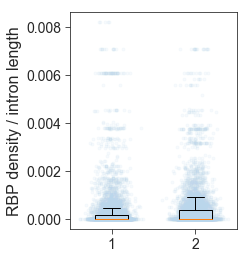

In [124]:
### Fig. 5G

# make boxplot the same way as the other ones in the paper
# plot distribution of intron lengths by splicing order

fig, ax = plt.subplots(figsize=(3,4))

# plotting length by splicing order K562 cells
y = splice_order_RBP_total['spliced']
x = np.random.normal(1, 0.1, size=len(y)) # Add some random "jitter" to the x-axis
ax.plot(x, y, '.', color=sns.color_palette("Blues")[1], alpha=0.1)

y = splice_order_RBP_total['unspliced']
x = np.random.normal(2, 0.1, size=len(y)) # Add some random "jitter" to the x-axis
ax.plot(x, y, '.', color=sns.color_palette("Blues")[1], alpha=0.1)

plot_list = [splice_order_RBP_total['spliced'],splice_order_RBP_total['unspliced']]
ax.boxplot(plot_list, 0, '', widths=0.4)

plt.ylabel("RBP density / intron length", fontsize=16)
    
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.tick_params(axis='both', which='both', labelsize=14, direction='out', left="on", bottom="on", length=5)

plt.savefig('/path/to/Figure_5G_total_RBP_density_allReads_spliced_vs_unspliced_boxplot.pdf', 
           format='pdf', dpi=300, bbox_inches='tight')

plt.show()

In [121]:
# Compare the two distributions using a standard t-test
t1,p1 = ttest_ind(splice_order_RBP_total['unspliced'], splice_order_RBP_total['spliced'], nan_policy='omit', equal_var=False)
t1,p1

(4.727870755159332, 2.2945812007242526e-06)

In [122]:
# Compare the two distributions using a paired (related) t-test
t2,p2 = scipy.stats.ttest_rel(splice_order_RBP_total['unspliced'], splice_order_RBP_total['spliced'], nan_policy='omit')
t2,p2

(7.247873998865474, 4.764774270953503e-13)

In [123]:
p = scipy.stats.ranksums(splice_order_RBP_total['unspliced'], splice_order_RBP_total['spliced'])[1]
print("RBP density ranksum p-value = "+str(p))


RBP density ranksum p-value = 3.851844808332202e-60


In [ ]:
### Fig. 5H

In [150]:
def get_intron_order_features_wiRBP(intron_pairs_df, intron_info):
    
    intron_pairs_df = intron_pairs_df[intron_pairs_df['int1_splice']!=intron_pairs_df['int2_splice']].reset_index(drop=True)
        
    features1 = pd.merge(intron_pairs_df, intron_info, left_on='int1_name', right_on='name', how='left')
    features2 = pd.merge(intron_pairs_df, intron_info, left_on='int2_name', right_on='name', how='left')
    
    combined = pd.concat([intron_pairs_df['read'],intron_pairs_df['strand']],axis=1)
    
    combined['chrom'] = 'NA'
    combined.loc[combined.strand=='+','chrom'] = features1['chrom_x']
    combined.loc[combined.strand=='-','chrom'] = features2['chrom_x']

    combined['start'] = 'NA'
    combined.loc[combined.strand=='+','start'] = features1['int1_start']
    combined.loc[combined.strand=='-','start'] = features2['int2_start']
    
    combined['end'] = 'NA'
    combined.loc[combined.strand=='+','end'] = features1['int2_end']
    combined.loc[combined.strand=='-','end'] = features2['int1_end']

    combined['name_1'] = 'NA'
    combined.loc[combined.strand=='+','name_1'] = features1['int1_name']
    combined.loc[combined.strand=='-','name_1'] = features2['int2_name']

    combined['length_1'] = 0
    combined.loc[combined.strand=='+','length_1'] = features1['intron_length']
    combined.loc[combined.strand=='-','length_1'] = features2['intron_length']

    combined['uElength_1'] = 0
    combined.loc[combined.strand=='+','uElength_1'] = features1['upstream_exon_length']
    combined.loc[combined.strand=='-','uElength_1'] = features2['upstream_exon_length']

    combined['dElength_1'] = 0
    combined.loc[combined.strand=='+','dElength_1'] = features1['downstream_exon_length']
    combined.loc[combined.strand=='-','dElength_1'] = features2['downstream_exon_length']

    combined['pos_1'] = 0
    combined.loc[combined.strand=='+','pos_1'] = features1['intron_pos']
    combined.loc[combined.strand=='-','pos_1'] = features2['intron_pos']

    combined['order_1'] = 0
    combined.loc[combined.strand=='+','order_1'] = features1['intron_order']
    combined.loc[combined.strand=='-','order_1'] = features2['intron_order']

    combined['trx_1'] = 0

    combined['MaxEnt5SS_1'] = 0.0
    combined.loc[combined.strand=='+','MaxEnt5SS_1'] = features1['MaxEnt_score_5SS']
    combined.loc[combined.strand=='-','MaxEnt5SS_1'] = features2['MaxEnt_score_5SS']

    combined['MaxEnt3SS_1'] = 0.0
    combined.loc[combined.strand=='+','MaxEnt3SS_1'] = features1['MaxEnt_score_3SS']
    combined.loc[combined.strand=='-','MaxEnt3SS_1'] = features2['MaxEnt_score_3SS']

    combined['RBP_1'] = 0.0
    combined.loc[combined.strand=='+','RBP_1'] = features1['RBP_density']
    combined.loc[combined.strand=='-','RBP_1'] = features2['RBP_density']

    combined['splice_1'] = 'NA'
    combined.loc[combined.strand=='+','splice_1'] = features1['int1_splice']
    combined.loc[combined.strand=='-','splice_1'] = features2['int2_splice']

    combined['alt_1'] = 'NA'
    combined.loc[combined.strand=='+','alt_1'] = features1['alt']
    combined.loc[combined.strand=='-','alt_1'] = features2['alt']
    combined.loc[combined.alt_1=='NO','alt_1'] = 0
    combined.loc[combined.alt_1=='YES','alt_1'] = 1
    combined.loc[combined.alt_1=='OTHER','alt_1'] = 1
        
   
    combined['name_2'] = 'NA'
    combined.loc[combined.strand=='+','name_2'] = features2['int2_name']
    combined.loc[combined.strand=='-','name_2'] = features1['int1_name']

    combined['length_2'] = 0
    combined.loc[combined.strand=='+','length_2'] = features2['intron_length']
    combined.loc[combined.strand=='-','length_2'] = features1['intron_length']
    
    combined['dElength_2'] = 0
    combined.loc[combined.strand=='+','dElength_2'] = features2['downstream_exon_length']
    combined.loc[combined.strand=='-','dElength_2'] = features1['downstream_exon_length']

    combined['pos_2'] = 0
    combined.loc[combined.strand=='+','pos_2'] = features2['intron_pos']
    combined.loc[combined.strand=='-','pos_2'] = features1['intron_pos']

    combined['order_2'] = 0
    combined.loc[combined.strand=='+','order_2'] = features2['intron_order']
    combined.loc[combined.strand=='-','order_2'] = features1['intron_order']

    combined['trx_2'] = 1

    combined['MaxEnt5SS_2'] = 0.0
    combined.loc[combined.strand=='+','MaxEnt5SS_2'] = features2['MaxEnt_score_5SS']
    combined.loc[combined.strand=='-','MaxEnt5SS_2'] = features1['MaxEnt_score_5SS']
    
    combined['MaxEnt3SS_2'] = 0.0
    combined.loc[combined.strand=='+','MaxEnt3SS_2'] = features2['MaxEnt_score_3SS']
    combined.loc[combined.strand=='-','MaxEnt3SS_2'] = features1['MaxEnt_score_3SS']

    combined['RBP_2'] = 0.0
    combined.loc[combined.strand=='+','RBP_2'] = features2['RBP_density']
    combined.loc[combined.strand=='-','RBP_2'] = features1['RBP_density']

    combined['splice_2'] = 'NA'
    combined.loc[combined.strand=='+','splice_2'] = features2['int2_splice']
    combined.loc[combined.strand=='-','splice_2'] = features1['int1_splice']

    combined['alt_2'] = 'NA'
    combined.loc[combined.strand=='+','alt_2'] = features2['alt']
    combined.loc[combined.strand=='-','alt_2'] = features1['alt']
    combined.loc[combined.alt_2=='NO','alt_2'] = 0
    combined.loc[combined.alt_2=='YES','alt_2'] = 1
    combined.loc[combined.alt_2=='OTHER','alt_2'] = 1

    
    combined['splice_order'] = 0
    combined.loc[combined.splice_1=='YES','splice_order'] = 0
    combined.loc[combined.splice_2=='YES','splice_order'] = 1

    return combined



def get_all_feature_importance_RandomForestClassifier_wiRBP(intron_pairs_df, intron_info, TEST_SIZE, RANDOM_STATE, SHUFFLE, N_ESTIMATORS):
    
    # removing duplicate intron pairs
    splicing_order_stats = get_intron_order_features_wiRBP(intron_pairs_df, intron_info)
    splicing_order_stats = splicing_order_stats.drop_duplicates(subset=['name_1','name_2']).reset_index(drop=True)

    features = pd.concat([splicing_order_stats['chrom'],splicing_order_stats['start'],splicing_order_stats['end'],
                          splicing_order_stats['name_1'], splicing_order_stats['length_1'], splicing_order_stats['MaxEnt5SS_1'], splicing_order_stats['MaxEnt3SS_1'],
                          splicing_order_stats['uElength_1'], splicing_order_stats['dElength_1'], splicing_order_stats['RBP_1'], splicing_order_stats['alt_1'],
                          splicing_order_stats['pos_1'], splicing_order_stats['order_1'], splicing_order_stats['trx_1'],
                          splicing_order_stats['name_2'], splicing_order_stats['length_2'], splicing_order_stats['MaxEnt5SS_2'], splicing_order_stats['MaxEnt3SS_2'],
                          splicing_order_stats['dElength_2'], splicing_order_stats['RBP_2'], splicing_order_stats['alt_2'],
                          splicing_order_stats['pos_2'], splicing_order_stats['order_2'], splicing_order_stats['trx_2'],
                          splicing_order_stats['splice_order']],axis=1)

    features = features.sort_values(by=['chrom','start','end'])
    features = features.drop(['chrom','start','end','name_1', 'name_2'], axis=1)

    features = pd.get_dummies(features)
  
    # Labels are the values we want to predict
    labels = np.array(features['splice_order'])

    # Remove the labels from the features
    # axis 1 refers to the columns
    features = features.drop('splice_order', axis = 1)

    # Saving feature names for later use
    feature_list = list(features.columns)

    # Convert to numpy array
    features = np.array(features)

    # Split the data into training and testing sets
    train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = TEST_SIZE, random_state = RANDOM_STATE, shuffle = SHUFFLE)

    # Instantiate model with 1000 decision trees
    rf = RandomForestClassifier(n_estimators = N_ESTIMATORS, random_state = RANDOM_STATE)

    # Train the model on training data
    rf.fit(train_features, train_labels);

    # Use the forest's predict method on the test data
    predictions = rf.predict(test_features)

    # make an ROC curve
    fpr_comb, tpr_comb, _ = roc_curve(test_labels, predictions)
    comb_auc = roc_auc_score(test_labels, predictions)

    # Get numerical feature importances
    importances = list(rf.feature_importances_)

    # List of tuples with variable and importance
    feature_importances = [(feature, round(importance, 4)) for feature, importance in zip(feature_list, importances)]

    # Sort the feature importances by most important first
    feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

    importance_list = []
    for pair in feature_importances:
        
        importance_list.append([pair[0],pair[1]])
        
    importance_df = pd.DataFrame(importance_list)
    importance_df.columns = ['Variable','Importance']
    
    return importance_df




def get_length_sequence_RBP_combined_features(splicing_order_stats):
    
    features = pd.concat([splicing_order_stats['chrom'],splicing_order_stats['start'],splicing_order_stats['end'],
                          splicing_order_stats['name_1'], splicing_order_stats['length_1'], splicing_order_stats['uElength_1'], splicing_order_stats['dElength_1'], splicing_order_stats['MaxEnt5SS_1'], splicing_order_stats['MaxEnt3SS_1'],
                          splicing_order_stats['RBP_1'], splicing_order_stats['name_2'], splicing_order_stats['length_2'], splicing_order_stats['dElength_2'], splicing_order_stats['MaxEnt5SS_2'], 
                          splicing_order_stats['MaxEnt3SS_2'], splicing_order_stats['RBP_2'], splicing_order_stats['splice_order']],axis=1)

    features = features.sort_values(by=['chrom','start','end']).reset_index(drop=True)
    features = features.drop(['chrom','start','end','name_1', 'name_2'], axis=1).reset_index(drop=True)

    features = pd.get_dummies(features)

    return features



def get_RBP_features(splicing_order_stats):
    
    features = pd.concat([splicing_order_stats['chrom'],splicing_order_stats['start'],splicing_order_stats['end'],
                          splicing_order_stats['name_1'], splicing_order_stats['RBP_1'],
                          splicing_order_stats['name_2'], splicing_order_stats['RBP_2'],
                          splicing_order_stats['splice_order']],axis=1)

    features = features.sort_values(by=['chrom','start','end']).reset_index(drop=True)
    features = features.drop(['chrom','start','end','name_1', 'name_2'], axis=1).reset_index(drop=True)

    features = pd.get_dummies(features)

    return features



def get_all_combined_features_wiRBP(splicing_order_stats):
    
    features = pd.concat([splicing_order_stats['chrom'],splicing_order_stats['start'],splicing_order_stats['end'],
                          splicing_order_stats['name_1'], splicing_order_stats['length_1'], splicing_order_stats['MaxEnt5SS_1'], splicing_order_stats['MaxEnt3SS_1'],
                          splicing_order_stats['uElength_1'], splicing_order_stats['dElength_1'], splicing_order_stats['RBP_1'], 
                          splicing_order_stats['alt_1'],splicing_order_stats['pos_1'], splicing_order_stats['order_1'],
                          splicing_order_stats['name_2'], splicing_order_stats['length_2'], splicing_order_stats['MaxEnt5SS_2'], splicing_order_stats['MaxEnt3SS_2'],
                          splicing_order_stats['dElength_2'], splicing_order_stats['RBP_2'], 
                          splicing_order_stats['alt_2'], splicing_order_stats['pos_2'], splicing_order_stats['order_2'],
                          splicing_order_stats['splice_order']],axis=1)

    features = features.sort_values(by=['chrom','start','end']).reset_index(drop=True)
    features = features.drop(['chrom','start','end','name_1', 'name_2'], axis=1).reset_index(drop=True)

    features = pd.get_dummies(features)

    return features


In [151]:
# get intron pairs plus names/coordinates
K562_1_intron_pairs_coord_df = get_intron_pairs_df(K562_1_splice_dictionary)
K562_2_intron_pairs_coord_df = get_intron_pairs_df(K562_2_splice_dictionary)
K562_3_intron_pairs_coord_df = get_intron_pairs_df(K562_3_splice_dictionary)
K562_4_intron_pairs_coord_df = get_intron_pairs_df(K562_4_splice_dictionary)
K562_5a_intron_pairs_coord_df = get_intron_pairs_df(K562_5a_splice_dictionary)
K562_5b_intron_pairs_coord_df = get_intron_pairs_df(K562_5b_splice_dictionary)
allK562_intron_pairs_df = pd.concat([K562_1_intron_pairs_coord_df,K562_2_intron_pairs_coord_df,K562_3_intron_pairs_coord_df,K562_4_intron_pairs_coord_df,K562_5a_intron_pairs_coord_df,K562_5b_intron_pairs_coord_df],axis=0)

allK562_intron_pairs_df['chrom'] = 'chr'+allK562_intron_pairs_df['chrom'].astype(str)
allK562_intron_pairs_df = allK562_intron_pairs_df.sort_values(by=['chrom','int1_start','int1_end']).reset_index(drop=True)


In [152]:
# Get total RBP density from original RBP file (prior to removing duplicates)
rbp_total_density_all = intron_df_sum.loc[:,rbp_list].sum(axis=1)

hg38_intron_total_all = pd.concat([intron_df_sum[['chrom','start','end','gene','intron_length','strand']],rbp_total_density_all],axis=1)
hg38_intron_total_all.columns = ['chrom','start','end','gene','intron_length','strand','RBP_density']
hg38_intron_total_all = hg38_intron_total_all.sort_values(by=['chrom','start','end']).reset_index(drop=True)


In [153]:
# Merge total RBP density with intron features file
hg38_intron_info_wiRBP = hg38_intron_info_wiAlt.merge(hg38_intron_total_all, on=['chrom','start','end','gene','intron_length','strand'],how='left')
hg38_intron_info_wiRBP_noDups = hg38_intron_info_wiRBP.drop_duplicates(subset=['chrom','start','end','strand']).reset_index(drop=True)
hg38_intron_info_wiRBP_noDups = hg38_intron_info_wiRBP_noDups.sort_values(by=['chrom','start','end']).reset_index(drop=True)


In [154]:
# get splicing order stats file
allK562_splicing_order_stats_wiRBP = get_intron_order_features_wiRBP(allK562_intron_pairs_df, hg38_intron_info_wiRBP)


In [155]:
# get importance levels for all features 

TEST_SIZE = 0.25
RANDOM_STATE = None
SHUFFLE = False
N_ESTIMATORS = 300

allK562_combined_importance_classifier = get_all_feature_importance_RandomForestClassifier_wiRBP(allK562_intron_pairs_df, hg38_intron_info_wiRBP, TEST_SIZE, RANDOM_STATE, SHUFFLE, N_ESTIMATORS)


In [156]:
allK562_combined_importance_classifier

,Variable,Importance
0,length_2,0.0910
1,length_1,0.0885
2,RBP_2,0.0836
3,MaxEnt5SS_1,0.0819
4,MaxEnt5SS_2,0.0812
5,MaxEnt3SS_1,0.0788
6,MaxEnt3SS_2,0.0754
7,dElength_1,0.0707
8,uElength_1,0.0706
9,dElength_2,0.0680


In [161]:
# collect features for K562
all_K562_RBP_features = get_RBP_features(allK562_splicing_order_stats_wiRBP)
all_K562_seq_length_combined_features = get_length_sequence_combined_features(allK562_splicing_order_stats_wiRBP)
all_K562_seq_length_RBP_combined_features = get_length_sequence_RBP_combined_features(allK562_splicing_order_stats_wiRBP)


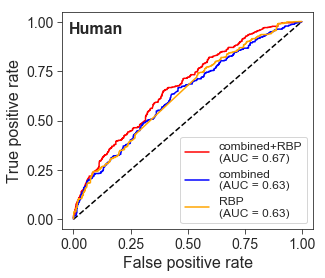

In [171]:
# K562 rf classifier

TEST_SIZE = 0.25
RANDOM_STATE = None
N_ESTIMATORS = 300
MAX_FEATURES = None
MAX_DEPTH = None
SHUFFLE = False

fpr_RBP, tpr_RBP, RBP_auc = get_random_forest_classifier_ROC(all_K562_RBP_features, TEST_SIZE, RANDOM_STATE, SHUFFLE, N_ESTIMATORS, MAX_FEATURES, MAX_DEPTH)
fpr_comb, tpr_comb, comb_auc  = get_random_forest_classifier_ROC(all_K562_seq_length_combined_features, TEST_SIZE, RANDOM_STATE, SHUFFLE, N_ESTIMATORS, MAX_FEATURES, MAX_DEPTH)
fpr_combRBP, tpr_combRBP, combRBP_auc = get_random_forest_classifier_ROC(all_K562_seq_length_RBP_combined_features, TEST_SIZE, RANDOM_STATE, SHUFFLE, N_ESTIMATORS, MAX_FEATURES, MAX_DEPTH)

plt.subplots(figsize=(4.5,4))

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_combRBP, tpr_combRBP, label='combined+RBP\n(AUC = %0.2f)' % (combRBP_auc), color='red')
plt.plot(fpr_comb, tpr_comb, label='combined\n(AUC = %0.2f)' % (comb_auc), color='blue')
plt.plot(fpr_RBP, tpr_RBP, label='RBP\n(AUC = %0.2f)' % (RBP_auc), color='orange')
plt.xlabel('False positive rate', fontsize=16)
plt.ylabel('True positive rate', fontsize=16)
plt.title('')
plt.legend(loc='best', fontsize=12)
plt.text(-.02, 1, 'Human', horizontalalignment='left', verticalalignment='top', fontsize=16, weight='bold')

plt.xticks([0.0,0.25,0.50,0.75,1.0],fontsize=16)
plt.yticks([0.0,0.25,0.50,0.75,1.0],fontsize=16)
plt.tick_params(axis='both', which='both', labelsize=14, direction='out', left="on", bottom="on", length=5)

plt.savefig('/path/to/Figure_5H_K562_splicing_order_RBP_model_ROC_plot.pdf', 
           format='pdf', dpi=300, bbox_inches='tight')

plt.show()


In [172]:
print('combined+RBP AUC = %0.2f' % (combRBP_auc))
print('combined AUC = %0.2f' % (comb_auc))
print('RBP AUC = %0.2f' % (RBP_auc))


combined+RBP AUC = 0.67
combined AUC = 0.63
RBP AUC = 0.63


In [173]:
# K562 rf classifier

TEST_SIZE = 0.25
RANDOM_STATE = None
N_ESTIMATORS = 300
MAX_FEATURES = None
MAX_DEPTH = None
SHUFFLE = False

all_K562_RBP_features_accuracy = get_random_forest_classifier_accuracy(all_K562_RBP_features, TEST_SIZE, RANDOM_STATE, SHUFFLE, N_ESTIMATORS, MAX_FEATURES, MAX_DEPTH)
all_K562_comb_features_accuracy = get_random_forest_classifier_accuracy(all_K562_seq_length_combined_features, TEST_SIZE, RANDOM_STATE, SHUFFLE, N_ESTIMATORS, MAX_FEATURES, MAX_DEPTH)
all_K562_combRBP_accuracy = get_random_forest_classifier_accuracy(all_K562_seq_length_RBP_combined_features, TEST_SIZE, RANDOM_STATE, SHUFFLE, N_ESTIMATORS, MAX_FEATURES, MAX_DEPTH)

print('RBP prediction accuracy: '+str(all_K562_RBP_features_accuracy))
print('combined prediction accuracy: '+str(all_K562_comb_features_accuracy))
print('combined+RBP prediction accuracy: '+str(all_K562_combRBP_accuracy))


RBP prediction accuracy: 0.57
combined prediction accuracy: 0.61
combined+RBP prediction accuracy: 0.66


In [234]:
TEST_SIZE = 0.25
RANDOM_STATE = None
N_ESTIMATORS = 300
MAX_FEATURES = None
MAX_DEPTH = None
SHUFFLE = False

K562_RBP_train_size, K562_RBP_test_size = get_random_forest_classifier_train_test_sizes(all_K562_seq_length_RBP_combined_features, TEST_SIZE, RANDOM_STATE, SHUFFLE, N_ESTIMATORS, MAX_FEATURES, MAX_DEPTH)
print("K562 train size: "+str(K562_RBP_train_size))
print("K562 test size: "+str(K562_RBP_test_size))


K562 train size: 4518
K562 test size: 1506


In [ ]:
### Fig. 5I

In [180]:
# Read splicing order dataframes that were calculated in the script nanoCOP_splicing_order_alt.ipynb
splicing_order_df_dm6 = pd.read_csv('/path/to/S2_alt_splicing_order_df.txt', sep='\t', index_col=0)
splicing_order_df_hg38 = pd.read_csv('/path/to/K562_alt_splicing_order_df.txt', sep='\t', index_col=0)


In [181]:
# Reorganize dataframe with the relevant columns
sub_df_dm6 = splicing_order_df_dm6[['two_const_txn_1st_spliced_1st','two_alt_txn_1st_spliced_1st', 'const_txn_1st_spliced_1st','alt_txn_1st_spliced_1st']].copy()
sub_df_dm6.columns = ['const-const','alt-alt','const-alt','alt-const']
sub_df_dm6['species'] = 'Drosophila'

sub_df_hg38 = splicing_order_df_hg38[['two_const_txn_1st_spliced_1st','two_alt_txn_1st_spliced_1st','const_txn_1st_spliced_1st','alt_txn_1st_spliced_1st']].copy()
sub_df_hg38.columns = ['const-const','alt-alt','const-alt','alt-const']
sub_df_hg38['species'] = 'Human'

# Concatenate the two species
sub_df = pd.concat([sub_df_hg38,sub_df_dm6])

# Melt the dataframe for plotting
plotting_df = sub_df.melt(id_vars=['species'])
plotting_df.columns = ['species','category','percent_first']


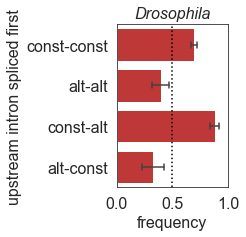

In [182]:
fig, ax = plt.subplots(figsize=(2,3))

sns.barplot(x="percent_first", y="category", data=plotting_df[plotting_df['species'] == 'Drosophila'], 
            color=sns.color_palette("Reds")[4], ci='sd', errwidth=1.5, capsize=.15)

plt.xlim(0,1)

plt.xticks([0,0.50,1], fontsize=16)
plt.yticks(fontsize=16)
plt.tick_params(direction='out', length=5, width=1)

plt.ylabel("upstream intron spliced first", fontsize=16)
plt.xlabel("frequency", fontsize=16)

plt.axvline(x=0.5, color='black', linestyle=":")

plt.title('Drosophila', fontsize=16, style="italic")


plt.savefig('/path/to/Figure_5I_S2_alt_splicing_order_plot.pdf', 
           format='pdf', dpi=300, bbox_inches='tight')

plt.show()

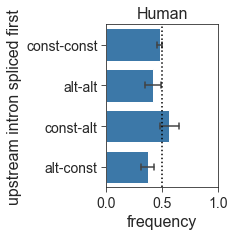

In [183]:
fig, ax = plt.subplots(figsize=(2,3))

sns.barplot(x="percent_first", y="category", data=plotting_df[plotting_df['species'] == 'Human'], 
            color=sns.color_palette("Blues")[4], ci='sd', errwidth=1.5, capsize=.15)

plt.xlim(0,1)

plt.xticks([0,0.50,1], fontsize=16)
plt.yticks(fontsize=16)
plt.tick_params(axis='both', which='both', labelsize=14, direction='out', left="on", bottom="on", length=5)

plt.ylabel("upstream intron spliced first", fontsize=16)
plt.xlabel("frequency", fontsize=16)

plt.axvline(x=0.5, color='black', linestyle=":")

plt.title('Human', fontsize=16)


plt.savefig('/path/to/Figure_5I_K562_alt_splicing_order_plot.pdf', 
           format='pdf', dpi=300, bbox_inches='tight')

plt.show()


In [184]:
# Read splicing order dataframes that were calculated in the script nanoCOP_splicing_order_alt.ipynb
splicing_order_counts_dm6 = pd.read_csv('/path/to/S2_alt_splicing_order_counts.txt', sep='\t', index_col=0)
splicing_order_counts_hg38 = pd.read_csv('/path/to/K562_alt_splicing_order_counts.txt', sep='\t', index_col=0)


In [421]:
# drosophila counts
splicing_order_counts_dm6[['two_const_txn_1st_spliced_1st','two_alt_txn_1st_spliced_1st', 'const_txn_1st_spliced_1st','alt_txn_1st_spliced_1st']].sum(axis=0)


two_const_txn_1st_spliced_1st    1771
two_alt_txn_1st_spliced_1st        23
const_txn_1st_spliced_1st          81
alt_txn_1st_spliced_1st            22
dtype: int64

In [422]:
splicing_order_counts_dm6.sum()

const_txn_1st_spliced_1st          81
const_txn_1st_spliced_2nd          11
alt_txn_1st_spliced_1st            22
alt_txn_1st_spliced_2nd            40
two_const_txn_1st_spliced_1st    1771
two_const_txn_1st_spliced_2nd     777
two_alt_txn_1st_spliced_1st        23
two_alt_txn_1st_spliced_2nd        38
dtype: int64

In [423]:
p = stats.binom_test([splicing_order_counts_dm6.sum()['two_const_txn_1st_spliced_1st'],splicing_order_counts_dm6.sum()['two_const_txn_1st_spliced_2nd']], n=None, p=0.5)
print("S2 C-C p-value: "+str(p))

p = stats.binom_test([splicing_order_counts_dm6.sum()['two_alt_txn_1st_spliced_1st'],splicing_order_counts_dm6.sum()['two_alt_txn_1st_spliced_2nd']], n=None, p=0.5)
print("S2 A-A p-value: "+str(p))

p = stats.binom_test([splicing_order_counts_dm6.sum()['const_txn_1st_spliced_1st'],splicing_order_counts_dm6.sum()['const_txn_1st_spliced_2nd']], n=None, p=0.5)
print("S2 C-A p-value: "+str(p))

p = stats.binom_test([splicing_order_counts_dm6.sum()['alt_txn_1st_spliced_1st'],splicing_order_counts_dm6.sum()['alt_txn_1st_spliced_2nd']], n=None, p=0.5)
print("S2 A-C p-value: "+str(p))


S2 C-C p-value: 2.0198542862677497e-88
S2 A-A p-value: 0.07217743850092248
S2 C-A p-value: 2.5015050632200827e-14
S2 A-C p-value: 0.03001586434906731


In [462]:
### Statistics comparing alignment to poly(A) sites between + and - polyA polymerase samples

# get values for Fisher exact test and Chi squared test
C_C_1st = splicing_order_counts_dm6.sum()['two_const_txn_1st_spliced_1st']
C_C_2nd = splicing_order_counts_dm6.sum()['two_const_txn_1st_spliced_2nd']
C_A_1st = splicing_order_counts_dm6.sum()['const_txn_1st_spliced_1st']
C_A_2nd = splicing_order_counts_dm6.sum()['const_txn_1st_spliced_2nd']

#np.array([[plus_A, plus_noA], [minus_A, minus_noA]])

oddsratio, pvalue = stats.fisher_exact([[C_C_1st, C_C_2nd], [C_A_1st, C_A_2nd]])
pvalue # the same equation in R shows that this is <2.2e-16

if (pvalue==0):
    print("Fisher exact p-value: <2.2e-16")

if (pvalue>0):
    print("Fisher exact p-value: "+str(pvalue))
      

g, pvalue, dof, expctd = chi2_contingency(np.array([[C_C_1st, C_C_2nd], [C_A_1st, C_A_2nd]]))
pvalue # the same equation in R shows that this is <2.2e-16

if (pvalue==0):
    print("chi-square p-value: <2.2e-16")

if (pvalue>0):
    print("chi-square p-value: "+str(pvalue))


Fisher exact p-value: 6.291569285452994e-05
chi-square p-value: 0.000214326570740601


In [466]:
### Statistics comparing alignment to poly(A) sites between + and - polyA polymerase samples

# get values for Fisher exact test and Chi squared test
C_C_1st = splicing_order_counts_dm6.sum()['two_const_txn_1st_spliced_1st']
C_C_2nd = splicing_order_counts_dm6.sum()['two_const_txn_1st_spliced_2nd']
A_C_1st = splicing_order_counts_dm6.sum()['alt_txn_1st_spliced_1st']
A_C_2nd = splicing_order_counts_dm6.sum()['alt_txn_1st_spliced_2nd']

#np.array([[plus_A, plus_noA], [minus_A, minus_noA]])

oddsratio, pvalue = stats.fisher_exact([[C_C_1st, C_C_2nd], [A_C_1st, A_C_2nd]])
pvalue # the same equation in R shows that this is <2.2e-16

if (pvalue==0):
    print("Fisher exact p-value: <2.2e-16")

if (pvalue>0):
    print("Fisher exact p-value: "+str(pvalue))
      

g, pvalue, dof, expctd = chi2_contingency(np.array([[C_C_1st, C_C_2nd], [A_C_1st, A_C_2nd]]))
pvalue # the same equation in R shows that this is <2.2e-16

if (pvalue==0):
    print("chi-square p-value: <2.2e-16")

if (pvalue>0):
    print("chi-square p-value: "+str(pvalue))


Fisher exact p-value: 7.80326811643557e-08
chi-square p-value: 2.5588007353562067e-08


In [467]:
### Statistics comparing alignment to poly(A) sites between + and - polyA polymerase samples

# get values for Fisher exact test and Chi squared test
C_C_1st = splicing_order_counts_dm6.sum()['two_const_txn_1st_spliced_1st']
C_C_2nd = splicing_order_counts_dm6.sum()['two_const_txn_1st_spliced_2nd']
A_A_1st = splicing_order_counts_dm6.sum()['two_alt_txn_1st_spliced_1st']
A_A_2nd = splicing_order_counts_dm6.sum()['two_alt_txn_1st_spliced_1st']

#np.array([[plus_A, plus_noA], [minus_A, minus_noA]])

oddsratio, pvalue = stats.fisher_exact([[C_C_1st, C_C_2nd], [A_A_1st, A_A_2nd]])
pvalue # the same equation in R shows that this is <2.2e-16

if (pvalue==0):
    print("Fisher exact p-value: <2.2e-16")

if (pvalue>0):
    print("Fisher exact p-value: "+str(pvalue))
      

g, pvalue, dof, expctd = chi2_contingency(np.array([[C_C_1st, C_C_2nd], [A_A_1st, A_A_2nd]]))
pvalue # the same equation in R shows that this is <2.2e-16

if (pvalue==0):
    print("chi-square p-value: <2.2e-16")

if (pvalue>0):
    print("chi-square p-value: "+str(pvalue))


Fisher exact p-value: 0.006039657965546054
chi-square p-value: 0.007407817005509323


In [185]:
# human counts
splicing_order_counts_hg38[['two_const_txn_1st_spliced_1st','two_alt_txn_1st_spliced_1st', 'const_txn_1st_spliced_1st','alt_txn_1st_spliced_1st']].sum(axis=0)


two_const_txn_1st_spliced_1st    2440
two_alt_txn_1st_spliced_1st       202
const_txn_1st_spliced_1st         239
alt_txn_1st_spliced_1st           209
dtype: int64

In [186]:
splicing_order_counts_hg38.sum()

const_txn_1st_spliced_1st         239
const_txn_1st_spliced_2nd         155
alt_txn_1st_spliced_1st           209
alt_txn_1st_spliced_2nd           342
two_const_txn_1st_spliced_1st    2440
two_const_txn_1st_spliced_2nd    2640
two_alt_txn_1st_spliced_1st       202
two_alt_txn_1st_spliced_2nd       264
dtype: int64

In [191]:
p = stats.binom_test([splicing_order_counts_hg38.sum()['two_const_txn_1st_spliced_1st'],splicing_order_counts_hg38.sum()['two_const_txn_1st_spliced_2nd']], n=None, p=0.5)
print("K562 C-C p-value: "+str(p))

p = stats.binom_test([splicing_order_counts_hg38.sum()['two_alt_txn_1st_spliced_1st'],splicing_order_counts_hg38.sum()['two_alt_txn_1st_spliced_2nd']], n=None, p=0.5)
print("K562 A-A p-value: "+str(p))

p = stats.binom_test([splicing_order_counts_hg38.sum()['const_txn_1st_spliced_1st'],splicing_order_counts_hg38.sum()['const_txn_1st_spliced_2nd']], n=None, p=0.5)
print("K562 C-A p-value: "+str(p))

p = stats.binom_test([splicing_order_counts_hg38.sum()['alt_txn_1st_spliced_1st'],splicing_order_counts_hg38.sum()['alt_txn_1st_spliced_2nd']], n=None, p=0.5)
print("K562 A-C p-value: "+str(p))


K562 C-C p-value: 0.005232692679956303
K562 A-A p-value: 0.004664681396527108
K562 C-A p-value: 2.7131344338335153e-05
K562 A-C p-value: 1.6045817083263853e-08


In [192]:
### Statistics comparing second alternative splicing order vs. 2 constitutive

# get values for Fisher exact test and Chi squared test
C_C_1st = splicing_order_counts_hg38.sum()['two_const_txn_1st_spliced_1st']
C_C_2nd = splicing_order_counts_hg38.sum()['two_const_txn_1st_spliced_2nd']
C_A_1st = splicing_order_counts_hg38.sum()['const_txn_1st_spliced_1st']
C_A_2nd = splicing_order_counts_hg38.sum()['const_txn_1st_spliced_2nd']

#np.array([[plus_A, plus_noA], [minus_A, minus_noA]])

oddsratio, pvalue = stats.fisher_exact([[C_C_1st, C_C_2nd], [C_A_1st, C_A_2nd]])
pvalue # the same equation in R shows that this is <2.2e-16

if (pvalue==0):
    print("Fisher exact p-value: <2.2e-16")

if (pvalue>0):
    print("Fisher exact p-value: "+str(pvalue))
      

g, pvalue, dof, expctd = chi2_contingency(np.array([[C_C_1st, C_C_2nd], [C_A_1st, C_A_2nd]]))
pvalue # the same equation in R shows that this is <2.2e-16

if (pvalue==0):
    print("chi-square p-value: <2.2e-16")

if (pvalue>0):
    print("chi-square p-value: "+str(pvalue))


Fisher exact p-value: 1.3780057005004937e-06
chi-square p-value: 1.767668932140822e-06


In [193]:
### Statistics comparing firt alternative splicing order vs. 2 constitutive

# get values for Fisher exact test and Chi squared test
C_C_1st = splicing_order_counts_hg38.sum()['two_const_txn_1st_spliced_1st']
C_C_2nd = splicing_order_counts_hg38.sum()['two_const_txn_1st_spliced_2nd']
A_C_1st = splicing_order_counts_hg38.sum()['alt_txn_1st_spliced_1st']
A_C_2nd = splicing_order_counts_hg38.sum()['alt_txn_1st_spliced_2nd']

#np.array([[plus_A, plus_noA], [minus_A, minus_noA]])

oddsratio, pvalue = stats.fisher_exact([[C_C_1st, C_C_2nd], [A_C_1st, A_C_2nd]])
pvalue # the same equation in R shows that this is <2.2e-16

if (pvalue==0):
    print("Fisher exact p-value: <2.2e-16")

if (pvalue>0):
    print("Fisher exact p-value: "+str(pvalue))
      

g, pvalue, dof, expctd = chi2_contingency(np.array([[C_C_1st, C_C_2nd], [A_C_1st, A_C_2nd]]))
pvalue # the same equation in R shows that this is <2.2e-16

if (pvalue==0):
    print("chi-square p-value: <2.2e-16")

if (pvalue>0):
    print("chi-square p-value: "+str(pvalue))


Fisher exact p-value: 6.685537411771852e-06
chi-square p-value: 7.938424295093904e-06


In [194]:
### Statistics comparing 2 alternative splicing order vs. 2 constitutive

# get values for Fisher exact test and Chi squared test
C_C_1st = splicing_order_counts_hg38.sum()['two_const_txn_1st_spliced_1st']
C_C_2nd = splicing_order_counts_hg38.sum()['two_const_txn_1st_spliced_2nd']
A_A_1st = splicing_order_counts_hg38.sum()['two_alt_txn_1st_spliced_1st']
A_A_2nd = splicing_order_counts_hg38.sum()['two_alt_txn_1st_spliced_1st']

#np.array([[plus_A, plus_noA], [minus_A, minus_noA]])

oddsratio, pvalue = stats.fisher_exact([[C_C_1st, C_C_2nd], [A_A_1st, A_A_2nd]])
pvalue # the same equation in R shows that this is <2.2e-16

if (pvalue==0):
    print("Fisher exact p-value: <2.2e-16")

if (pvalue>0):
    print("Fisher exact p-value: "+str(pvalue))
      

g, pvalue, dof, expctd = chi2_contingency(np.array([[C_C_1st, C_C_2nd], [A_A_1st, A_A_2nd]]))
pvalue # the same equation in R shows that this is <2.2e-16

if (pvalue==0):
    print("chi-square p-value: <2.2e-16")

if (pvalue>0):
    print("chi-square p-value: "+str(pvalue))


Fisher exact p-value: 0.4690303382729383
chi-square p-value: 0.4774540552089098
